# **Fundamentals of Data Science - Winter Semester 2024**


##### Matteo Migliarini (TA), Matteo Rampolla (TA) and Prof. Indro Spinelli
<migliarini.1886186@studenti.uniroma1.it>, <rampolla.1762214@studenti.uniroma1.it>, <spinelli@di.uniroma1.it>

---

## **#1 Homework: Image Filtering and Object Identification**

This first homework covers the main topics discussed in class.
Initially, you will be dealing with the original **Image Filtering** methods (*Question 1*), then you will have to work with **Edge Detection** algorithms (*Question 2*), and lastly, you are going to operate first-hand on **Object Identification** techniques (*Question 3*).
Additionally, the homework will contain written questions and reports where you will be asked to write down your answer in Markdown language.
The maximum possible grade is 30, but notice that you have 5 extra bonus points scattered across the homework to further boost your grade.

*Note: your task is to fill in the missing code where you see `"YOUR CODE HERE"` and the text part `"WRITE YOU ANSWER HERE"` part corresponding to each subproblem and produce brief reports on the results whenever necessary.*

As part of the homework, provide the answer to questions in this notebook report-like manner. After you have implemented all the missing code in the required sections, you will be able to run all the code without any errors. We kindly ask you to double-check this since **all** the delivered homework will be executed.

The completed exercise should be handed in as a single notebook file. Use Markdown to provide equations. Use the code sections to provide your scripts and the corresponding plots.

-------------------------------------

**Submit it** by sending an email to:

 **<migliarini.1886186@studenti.uniroma1.it>, <rampolla.1762214@studenti.uniroma1.it> and <spinelli@di.uniroma1.it> by Sunday 27th October 23:59**.

-------------------------------------

**Outline and Scores for #1 Homework:**


* **Question 1: Image Filtering** *(7 points)*
  * **Question 1.0: Warm Up** *(1 point)*
  * **Question 1.1: 1D Filters** *(3 points)*
  * **Question 1.2: 2D Filters** *(3 points)*

* **Question 2: Multi-Scale Image Representations** *(12 points)*
  * **Question 2.1: Prewitt Operator** *(2 point)*
  * **Question 2.2: Canny Edge Detector and Template Matching** *(4 points)*
  * **Question 2.3: Harris Corner Detector** *(2 points)*
  * **Question 2.4: Gaussian Pyramid and Aliasing** *(2 points)*
  * **Question 2.5: Multi-Scale Template Matching** *(2 points)*

* **Question 3: Object Identification** *(10 points)*
  * **Question 3.1: 3D Joint Color Histogram** *(2 points)*
  * **Question 3.2: Types of Histograms** *(2 points)*
  * **Question 3.3: Histogram Metrics** *(2 points)*
  * **Question 3.4: Image Retrieval** *(2 points)*
  * **Report** *(2 points)*

* **Question 4: Performance Evaluation** *(6 points)*
  * **Question 4.1: Performance Evaluation** *(2 point)*
  * **Question 4.2: Closest Neighbours** *(2 points)*
  * **Question 4.3: Retrieval Metrics** *(1 points)*
  * **Question 4.4: Analysis and Report** *(1 point)*


**TOTAL POINTS ARE 35, MAX GRADE IS 30**


## **Question 1: Image Filtering *(8 Points)***

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Set to True the first time you run this file to install the required packages
'''
install_packages = True
if install_packages:
    %pip install pandas pillow numpy scipy matplotlib opencv-python scikit-image scikit-learn
'''

'\ninstall_packages = True\nif install_packages:\n    %pip install pandas pillow numpy scipy matplotlib opencv-python scikit-image scikit-learn\n'

In [8]:
## import packages
import numpy as np
import pandas as pd
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import math
from scipy.ndimage import convolve1d
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
from typing import List, Tuple, Optional, Dict, Union

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression

plt.rcParams["figure.figsize"] = (20, 8)

In [9]:
def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    """
    Converts RGB images to grayscale.

    Args:
        rgb (np.ndarray): RGB image.

    Returns:
        gray (np.ndarray): Grayscale image.
    """
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def plot_pictures(
    imgs: List[np.ndarray],
    xlabels: List[str],
    nrows: int,
    ncols: int,
    show: bool = True,
    cmap: Union[str, List[str]] = "gray",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    same_scale: bool = False,
) -> List[plt.Axes]:
    """
    Plots images in a grid.

    Args:
        imgs (list[np.ndarray]): List of images.
        xlabels (list[str]): List of xlabels.
        nrows (int): Number of rows.
        ncols (int): Number of columns.
        show (bool): Whether to show the plot.
        cmap (Union[str, List[str]]): Color map.
        vmin (float): Minimum value.
        vmax (float): Maximum value.
        same_scale (bool): Whether to use the same scale for all images.

    Returns:
        axs (list[matplotlib.axes._subplots.AxesSubplot]): List of axes.
    """
    fig, axs = plt.subplots(nrows, ncols,
                            width_ratios=[img.shape[1] / img.shape[0] for img in imgs],
                            sharey=same_scale,
                            figsize=(ncols * 4, nrows * 4))
    axs = axs.flatten()

    for i, (img, ax) in enumerate(zip(imgs, axs)):
        if isinstance(cmap, list):
            current_cmap = cmap[i]
        else:
            current_cmap = cmap
        im = ax.imshow(img, cmap=current_cmap, vmin=vmin, vmax=vmax)


        ax.set_title(xlabels[i])
        ax.axis('off')
    plt.tight_layout()

    if show:
        plt.show()
    else:
        return axs

#### **1.0: Warm Up *(1 points)***

##### **Convolution**

The convolution is defined as $f[m,n]=I \ast g= \sum_{k,l} I[m-k,n-l]g[k,l]$ and is a linear operator, thus the following properties hold:
* *Homogeneity*: $T[aX]=aT[X]$
* *Additivity* : $T[X_1+X_2]=T[X_1]+T[X_2]$
* *Superposition*: $T[aX_1+bX_2]=aT[X_1]+bT[X_2]$

Prove mathematically the additivity of convolution.

-------------------------------------------------------

**WRITE YOU ANSWER HERE**

Write it in Markdown, you are encouraged to take a look at the cells in this notebook.
You can find a cheat sheet [here](https://www.markdownguide.org/basic-syntax)

-------------------------------------------------------

### Introduction
Just to give us some background and introduce the main terms:
-  $I[m, n]$ is the input function, like an image for instance

- - $I[m−k,n−l]$ means the input function is shifted by $k$ and $l$, depending on where the filter is positioned.

- $g[k, l]$ is the kernel that modifies the input also called filter
- - $(k,l)$ is the position of filter
- The sum $\sum_{k,l}$ tells you that you are taking this filter and sliding it across every possible position of the input.

You multiply these values together at each point where the filter and input overlap, then sum them all up to get a single number for that specific position of the filter.




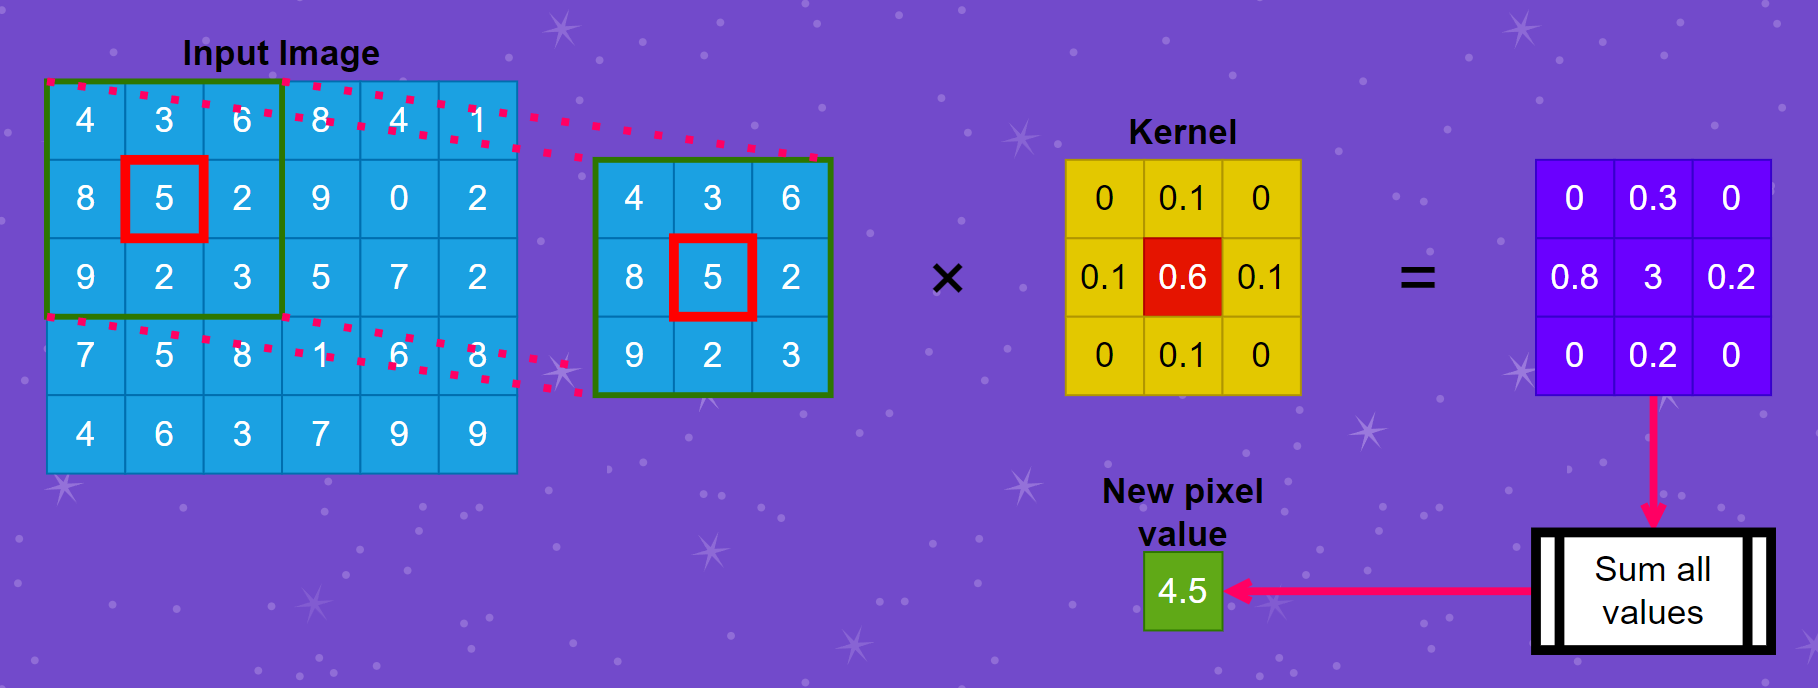
### But what is Additivity?

In our particular case, **Additivity** is a property that says when you combine two input signals and then apply the convolution, you get the same result as if you had applied the convolution to each signal separately and then combined the results.

### Additivity

The additivity property states:


$T[X_1 + X_2] = T[X_1] + T[X_2]$


This means that if you apply convolution to the sum of two signals $(I1+I2)$, the result will be the same as if you had first convolved $I1$ with the filter and then $I2$ with the filter, and finally added the two results.

### Mathematical Proof of Additivity


Given two functions $I_1[m,n]$ and $I_2[m,n]$, the convolution of their sum with a function $g[m,n]$ is:


$(I_1 + I_2) \ast g$ = $\sum_{k,l} (I_1[m-k,n-l] + I_2[m-k,n-l])g[k,l]$


Using the distributive property of summation allow us to split the sum into two parts:


= $\sum_{k,l} I_1[m-k,n-l]g[k,l] + \sum_{k,l} I_2[m-k,n-l]g[k,l]$

We can recognize that each of these sums is a convolution. The first sum is $I1 \ast g$ and the second sum is $I2 \ast g$

This is means that the formula above is equivalent to:


= $I_1 \ast g + I_2 \ast g$


Thus, we have shown that:

$T[I_1 + I_2] = T[I_1] + T[I_2]$

Additivity is important because it tells us that convolution is a **linear operation**. In simpler terms, it means that convolution behaves predictably when dealing with sums of signals.

### Notes
Markdown looks like Latex, math it's literally the same

### Sources
How it works:
https://starbeamrainbowlabs.com/blog/article.php?article=posts%2F467-worldeditadditions-convolve.html

Understaing of Convolutions's properties:
https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Signal_Processing_and_Modeling/Signals_and_Systems_(Baraniuk_et_al.)/03%3A_Time_Domain_Analysis_of_Continuous_Time_Systems/3.04%3A_Properties_of_Continuous_Time_Convolution

Understanding of the properties that makes convolution a linear operator:
https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch7.pdf



**Exercise on convolutions**

Usually, to be consistent with the definition, we use zero padding: this practice consists of adding a border of zero-valued pixels all around the edges of the input image.
In our case, we will have

\begin{equation}
f[m,n] =
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 4 & 5 & 7 & 0 \\
0 & 7 & 3 & 1 & 0 \\
0 & 9 & 2 & 2 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{pmatrix}
*\begin{pmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{pmatrix}
=\begin{pmatrix}
... & ... & ... \\
... & -10 & ... \\
... & ... & ... \\
\end{pmatrix}.
\end{equation}

Now, given the images $I_1 \in \mathbb{N}^{5 \times 5}$, $I_2 \in \mathbb{N}^{5 \times 5}$, and the kernel $g \in \mathbb{N}^{2 \times 2}$, apply the additivity property for one convolution operation: you should expect that $T[I_1 + I_2]$ and $T[I_1]$ + $T[I_2]$ get the same result.
Displaying explicitly the operations you performed, feel free to choose the coordinates to apply the convolution on as you like them.

\begin{equation}
    I_1 =
    \begin{pmatrix}
        0 & 0 & 0 & 0 & 0 \\
        0 & 3 & 3 & 5 & 0 \\
        0 & 2 & 7 & 0 & 0 \\
        0 & 0 & 2 & 3 & 0 \\
        0 & 0 & 0 & 0 & 0 \\
    \end{pmatrix}, \quad
    I_2 =
    \begin{pmatrix}
        0 & 0 & 0 & 0 & 0 \\
        0 & 3 & 5 & 3 & 0 \\
        0 & 1 & 0 & 5 & 0 \\
        0 & 2 & 6 & 8 & 0 \\
        0 & 0 & 0 & 0 & 0 \\
    \end{pmatrix}, \quad
    g =
    \begin{pmatrix}
        -1 & 1 \\
        -1 & 1 \\
    \end{pmatrix}
\end{equation}

-------------------------------------------------------

**WRITE YOU ANSWER HERE**

Write it in Markdown, you are encouraged to take a look at the cells in this notebook.
You can find a cheat sheet [here](https://www.markdownguide.org/basic-syntax)

-------------------------------------------------------

### Exercise on Convolution with Additivity Property

We are given two matrices $I_1$ and $I_2$, and a kernel $g$, and we need to apply the **additivity property** of convolution, proved in the previous task.

This means that convolving the sum of two input matrices with a filter should give the same result as convolving each matrix separately and then adding the results.

### Step 1: Adding $I_1$ and $I_2$

We have


$I_1$ = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 3 & 3 & 5 & 0 \\
0 & 2 & 7 & 0 & 0 \\
0 & 0 & 2 & 3 & 0 \\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
$I_2$ = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 3 & 5 & 3 & 0 \\
0 & 1 & 0 & 5 & 0 \\
0 & 2 & 6 & 8 & 0 \\
0 & 0 & 0 & 0 & 0
\end{pmatrix}

Adding them element-wise, so one by one we have:

$I_1 + I_2$ = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 6 & 8 & 8 & 0 \\
0 & 3 & 7 & 5 & 0 \\
0 & 2 & 8 & 11 & 0 \\
0 & 0 & 0 & 0 & 0
\end{pmatrix}


### Step 2: Convolution of $I_1 + I_2$ with Kernel $g$

The kernel is:

$g$ = \begin{pmatrix}
-1 & 1 \\
-1 & 1
\end{pmatrix}

Let’s apply the convolution at the central position, so we take the 2x2 composed by
\
$[(3, 3), (3, 4), (4, 3)$ and $(4, 4)]$ of $I_1 + I_2$ [called $position (3, 3)$]

\begin{pmatrix}
7 & 5 \\
8 & 11
\end{pmatrix}

Apply the kernel:


$(-1 \times 7) + (1 \times 5) + (-1 \times 8) + (1 \times 11) = -7 + 5 - 8 + 11 = 1$

So, $T[I_1 + I_2]$ at $position (3, 3)$ is $1$.

### Step 3: Convolution of $I_1$ and $I_2$ Separately

#### For $I_1$:

Take the 2x2 region around (3, 3):

\begin{pmatrix}
7 & 0 \\
2 & 3
\end{pmatrix}

Apply the kernel:

$(-1 \times 7) + (1 \times 0) + (-1 \times 2) + (1 \times 3) = -7 + 3 - 2 + 3 = -6$

#### For $I_2$:

Take the 2x2 region around (3, 3):

\begin{pmatrix}
0 & 5 \\
6 & 8
\end{pmatrix}

Apply the kernel:


$(-1 \times 0) + (1 \times 5) + (-1 \times 6) + (1 \times 8) = 0 + 5 - 6 + 8 = 7$

Now sum the results of $T[I_1]$ and $T[I_2]$:

$-6 + 7 = 1$

### Step 4: Compare the Results

- The result of $T[I_1 + I_2]$ at position (3, 3) is \( 1 \).
- The sum $T[I_1] + T[I_2]$ at position (3, 3) is \( 1 \).

### Conclusion

The results are the same, confirming that the additivity property holds in this case, as expected



In [10]:
# init images and kernel
I1 = np.array([
    [0,0,0,0,0],
    [0,3,3,5,0],
    [0,2,7,0,0],
    [0,0,2,3,0],
    [0,0,0,0,0]
], dtype=np.int32)
I2 = np.array([
    [0,0,0,0,0],
    [0,3,5,3,0],
    [0,1,0,5,0],
    [0,2,6,8,0],
    [0,0,0,0,0]
], dtype=np.int32)
g = np.array([
    [-1,1],
    [-1,1]
], dtype=np.int32)

I1_I2 = np.add(I1, I2)
print("Result of addition of images:")
print(I1_I2)

# Reverse the kernel
g_reversed = np.flip(g)
print("Flipped kernel g:")
print(g_reversed)

# Convolution of images
f = convolve2d(I1_I2, g, mode='valid')
print("Result of convolution:")
print(f)

Result of addition of images:
[[ 0  0  0  0  0]
 [ 0  6  8  8  0]
 [ 0  3  7  5  0]
 [ 0  2  8 11  0]
 [ 0  0  0  0  0]]
Flipped kernel g:
[[ 1 -1]
 [ 1 -1]]
Result of convolution:
[[ -6  -2   0   8]
 [ -9  -6   2  13]
 [ -5 -10  -1  16]
 [ -2  -6  -3  11]]


### **1.1: 1D Filters *(3 Points)***


##### **1.1.1: 1-D Gaussian Filter**

Implement a method which computes the values of a 1-D Gaussian $G_x$ for a given standard deviation $\sigma$ and filter size $k$.:
\begin{equation}
G(x)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{x^2}{2\sigma^2}\right)
\end{equation}

The method should return a vector $x$ of values on which the Gaussian filter is defined: integer values on the interval $\left[-k\sigma,k\sigma\right]$.

With $\sigma=3$ and $k=3$ you should get the following output:

![](./images/1gauss.png)

In [11]:
def gauss(sigma: int, filter_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the Gaussian filter.

    Args:
        sigma (int): Standard deviation (controls the "width" of the bell curve).
        filter_size (int): Filter size, be wary that it is the full size of the filter.

    Returns:
        Gx (np.ndarray): Gaussian filter values.
        x (np.ndarray): Array of integer values(x) over which the filter is computed.
    """
    # Define range
    x = np.arange(-filter_size * sigma, filter_size * sigma + 1)
    # This solution has more direct control over the number of points in the filter, as it limits the range to be proportional to filter_size (based on sigma).
    # Gaussian formula here:
    Gx = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x**2) / (2 * sigma**2))
    Gx /= Gx.sum() #normalize since if not done result is not exactly 0
    return Gx, x


The filter is calculated over a symmetric range from $- k \sigma$ to $k \sigma$.

We need to add +1 to include both endpoints of the interval since in py the stop value is exclusive, meaning the range will stop before reaching the stop value.

A Gaussian filter is used to smooth data by weighting the values near a certain point based on a Gaussian distribution. This is commonly used in image and signal processing to reduce noise.

--------------------------------------------

**Do not write below this line just run it**

--------------------------------------------

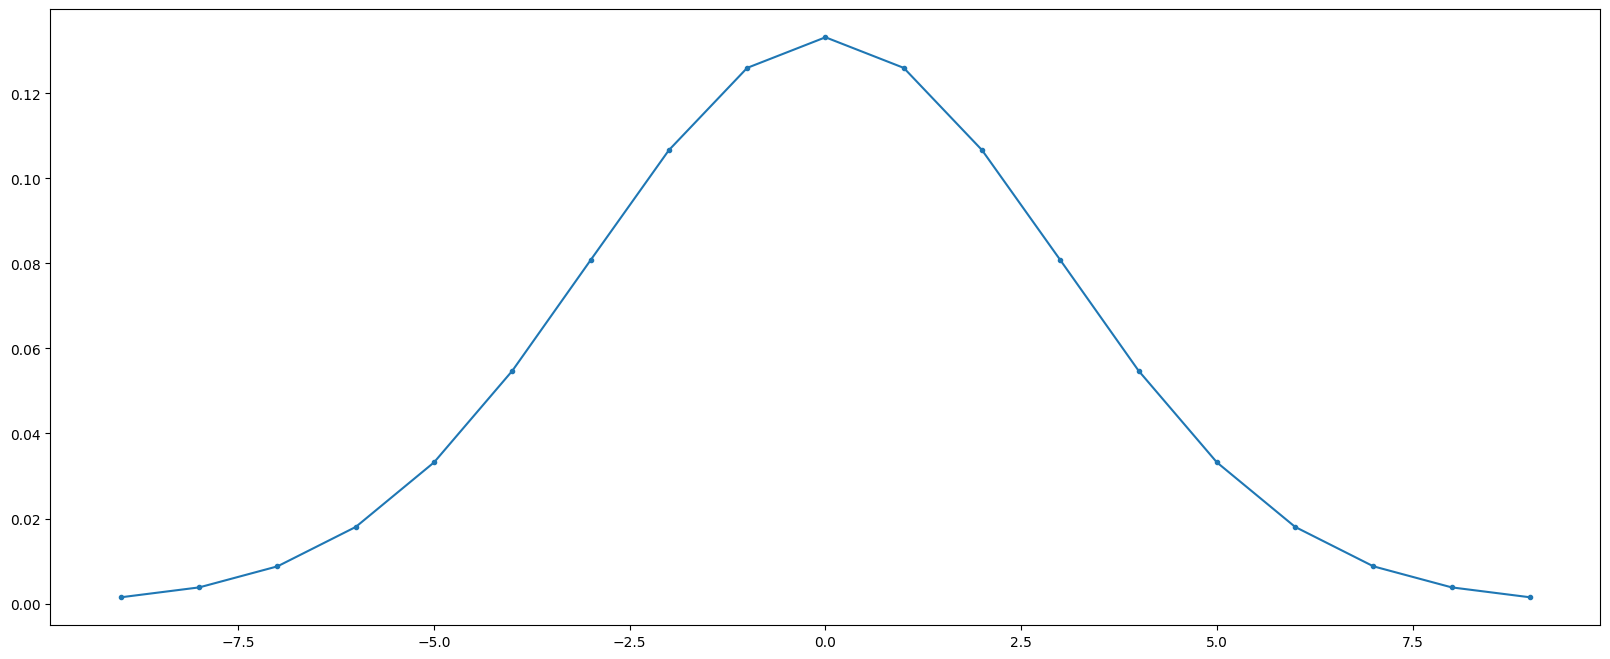

In [12]:
sigma = 3
kappa = 3
Gx, x = gauss(sigma, kappa)
plt.figure(1)
plt.plot(x, Gx, ".-")
plt.show()

In [13]:
# Testing normalization of Gaussian kernel
gaussian_kernel, _ = gauss(sigma, kappa)
gaussian_sum = gaussian_kernel.sum()

gaussian_sum

1.0000000000000002

**Variation of $\sigma$ and filter size**

Now we generate a signal and apply the Gauss filter with different values of $\sigma$ and filter size.
Write down your considerations.

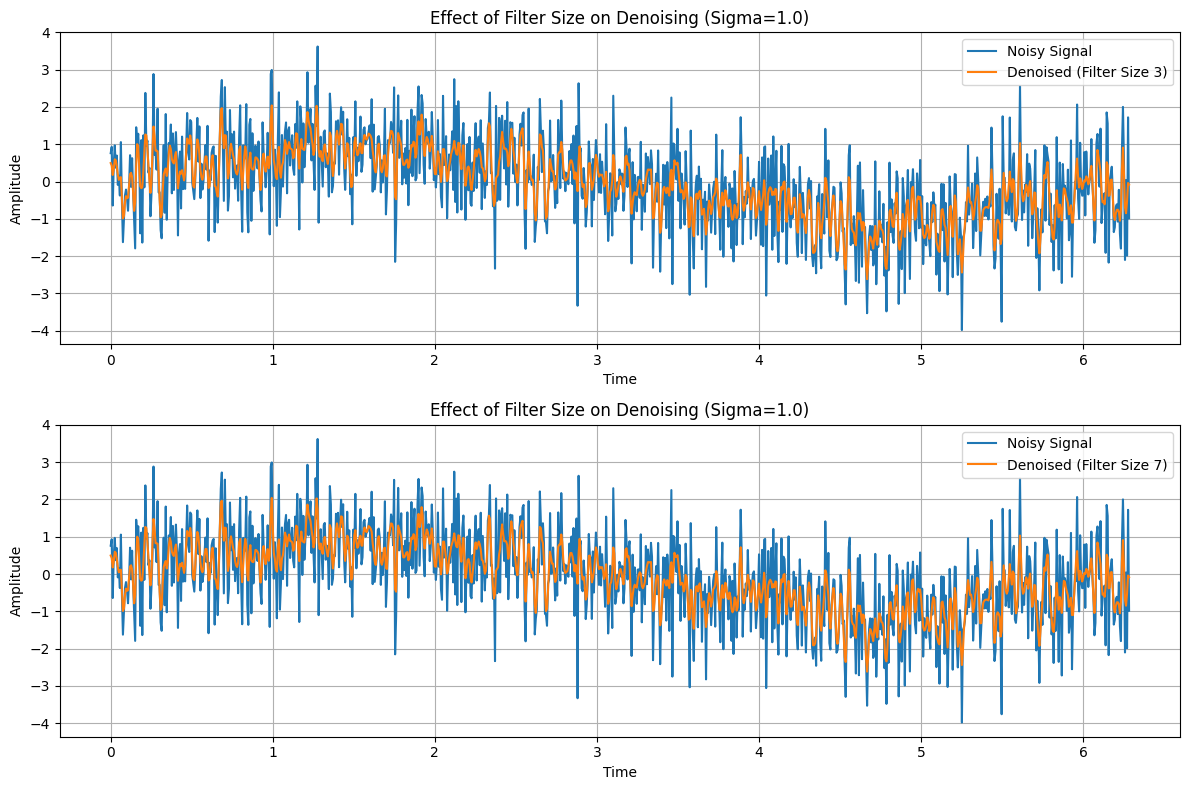

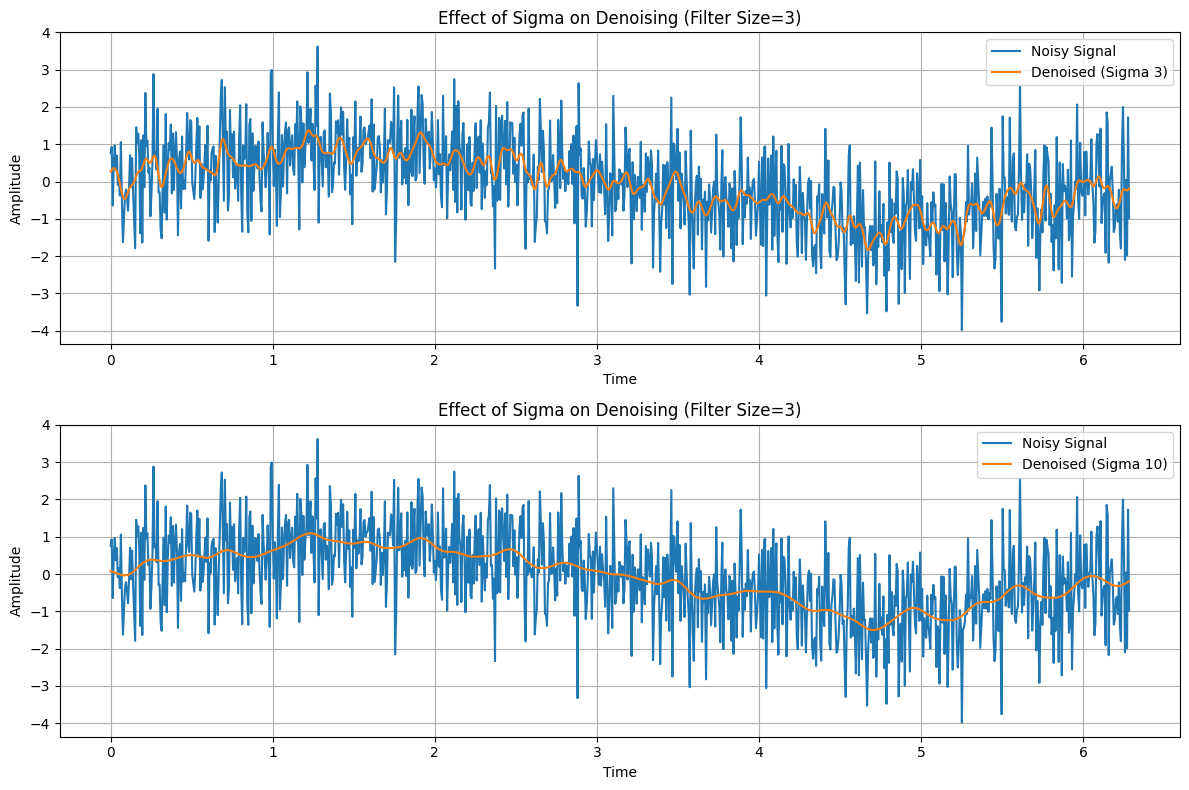

In [14]:
# Generate a noisy signal with increased noise (example data)
t = np.linspace(0, 2 * np.pi, 1000)
noisy_signal = np.sin(t) + 1.0 * np.random.randn(len(t))  # Increased noise

# Define a fixed sigma value
sigma = 1.0

# Define a range of filter sizes to test
filter_sizes = [3, 7]

# Create subplots to compare the denoising results
plt.figure(figsize=(12, 8))

for i in range(len(filter_sizes)):
    # Get the Gaussian kernel and x values from the custom gauss function
    Gx, x = gauss(sigma, filter_sizes[i])

    # Convolve the noisy signal with the Gaussian filter
    denoised_signal = np.convolve(noisy_signal, Gx, mode="same")

    # Plot the noisy and denoised signals for the current filter_size
    plt.subplot(len(filter_sizes), 1, i + 1)
    plt.plot(t, noisy_signal, label="Noisy Signal")
    plt.plot(t, denoised_signal, label=f"Denoised (Filter Size {filter_sizes[i]})")
    plt.title(f"Effect of Filter Size on Denoising (Sigma={sigma})")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# Define a fixed sigma value
sigma = [3, 10]

# Define a range of filter sizes to test
filter_sizes = 3

# Create subplots to compare the denoising results
plt.figure(figsize=(12, 8))

for i in range(len(sigma)):
    # Get the Gaussian kernel and x values from the custom gauss function
    Gx, x = gauss(sigma[i], filter_sizes)
    denoised_signal = np.convolve(noisy_signal, Gx, mode="same")

    # Plot the noisy and denoised signals for the current filter_size
    plt.subplot(len(sigma), 1, i + 1)
    plt.plot(t, noisy_signal, label="Noisy Signal")
    plt.plot(t, denoised_signal, label=f"Denoised (Sigma {sigma[i]})")
    plt.title(f"Effect of Sigma on Denoising (Filter Size={filter_sizes})")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

-------------------------------------------------------

**WRITE YOU ANSWER HERE**

-------------------------------------------------------

In the First Set of Graphs we evaluate the effect of different filter sizes (3 and 7), tested with a fixed $\sigma = 1.0$.

In Second Set of Graphs the effect of different sigma values (3 and 10) is tested with a fixed filter size = 3.

The noisy signal (blue line) used in all four graphs is the same, and it is generated by adding Gaussian noise to a sine wave.

Let's focus on Denoised Signal (orange line) for all the four graphs one by one:

- With a **small filter size (3)**, the Gaussian filter is applied over a small window. As a result, the smoothing effect is moderate. Some of the noise is removed, details are preserved  but we still have high-frequency noise.

- **With a larger filter size (7)**, the filter theoretically averages over a larger window, providing stronger smoothing. This should result in more noise being removed from the signal, but with a potential loss of fine details, leading to a smoother overall output. However, in our case, the denoised signals with filter sizes of 3 and 7 appear nearly identical when overlapped.

The **Filter Size** determines the support of the kernel but has a limited impact on the smoothing effect

- **With a moderate $\sigma = 3$**, the Gaussian curve is wider, which means the filter applies more smoothing. The noise is reduced while maintaining some signal details. The result is a smoother signal compared to the noisy input, but the smoothing is not too aggressive.

- **With a moderate $\sigma = 10$**, the Gaussian function becomes much wider, causing the filter to average over a larger range of points, which significantly reduces the noise (flatter) but potentially losing fine details.


##### **1-D Box Filter**

Implement a method that computes the values of a 1-D Box $B_x$ for a given standard deviation $\sigma$:
\begin{equation}
B= \left[\frac{1}{n},\frac{1}{n},\dots,\frac{1}{n}\right] \in \mathbb{R}^n
\end{equation}

The method should also return a vector $x$ of values on which the filter is defined: integer values in the interval $\left[-\kappa,\kappa\right]$ where $2\kappa =$ `filter_size`.

An example of a Box Filter:

![](./images/1box.png)

A box filter (also known as a mean filter) is a type of smoothing filter that averages the values over a given window of data points. In 1D, it slides over a signal and replaces each value with the average of its neighbors within the filter window. It’s one of the simplest forms of filters used in signal processing and image processing.



In [15]:
def box(filter_size: int = 3) -> Tuple[np.ndarray, np.ndarray]:
    """
    Box filter.
    A box filter is a simple filter where each element has the same value (1/n)
    Args:
        filter_size (int): Filter size.

    Returns:
        Bx (np.ndarray): Box filter.
        x (np.ndarray): x values.
    """
    k = filter_size // 2
    x = np.arange(-k, k + 1) # this solution  has direct control over the exact number of points in filter_size, this keep the filter symmetric and within a fixed range
    Bx = np.ones(filter_size) / filter_size

    # normalizing step
    Bx /= np.sum(Bx)

    return Bx, x

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

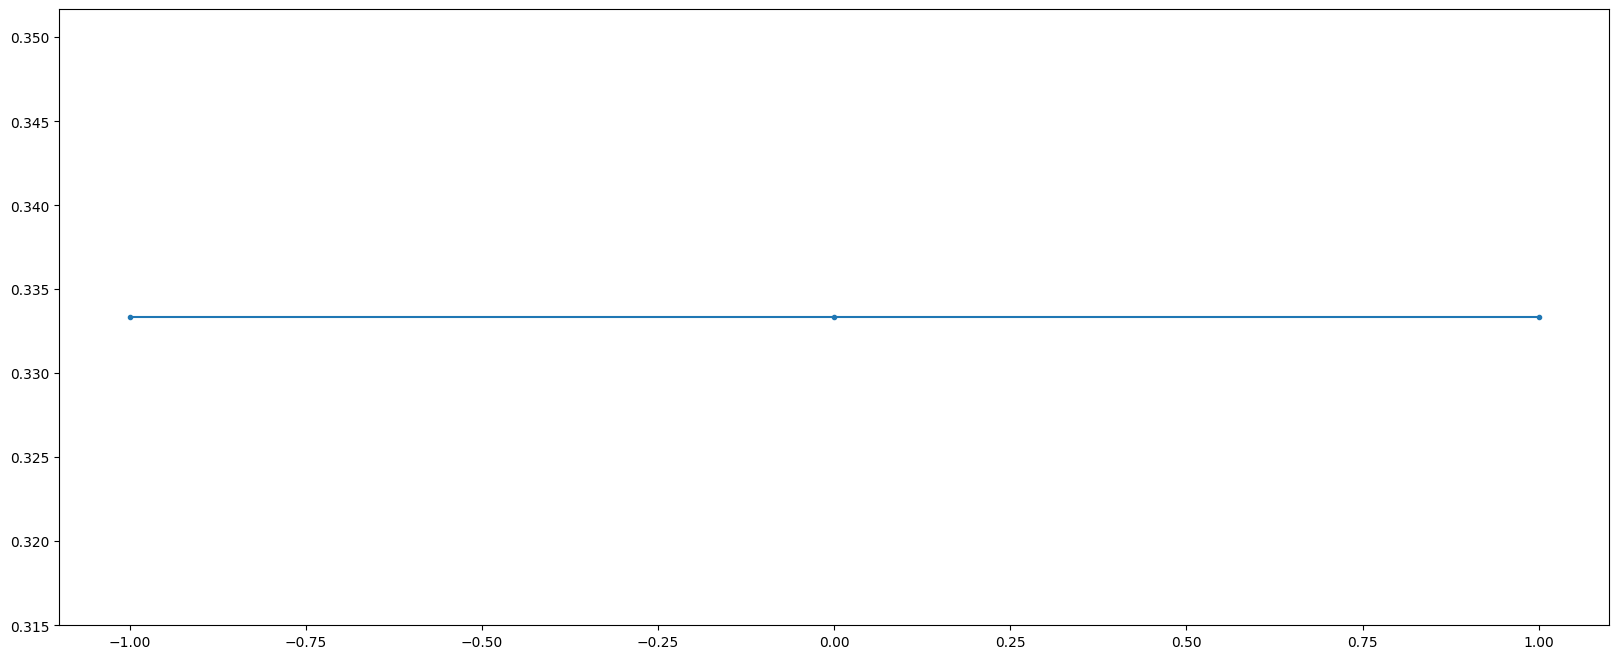

In [16]:
## function box
size = 3
Bx, x = box(size)
plt.figure(1)
plt.plot(x, Bx, ".-")
plt.show()

##### **1.1.2: 1D Laplacian filter**

Derive the 1-D Laplacian $L_x$, then implement a method that computes it for a given standard deviation $\sigma$ and filter size $k$:

With $\sigma=3$ and $k=10$ you shouls expect the following output:

![](./images/1laplace.png)

-------------------------------------------------------
**WRITE YOU ANSWER HERE**

Straight answers not showing the derivation steps will not be accepted.

\begin{equation}
\frac{d^2G(x)}{dx^2}=
\end{equation}

### Derivation of the 1D Laplacian

The Gaussian function is given by:

$$
G(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( \frac{-x^2}{2\sigma^2} \right)
$$

#### Step 1: First Derivative of the Gaussian Function

To compute the Laplacian (second derivative), we first compute the first derivative $G(x)$ with respect to $x$:

$$
\frac{dG(x)}{dx} = \frac{d}{dx} \left[ \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( \frac{-x^2}{2\sigma^2} \right) \right]
$$


Breaking this down:

$$
= \frac{1}{\sqrt{2\pi}\sigma} \cdot \frac{d}{dx} \left[ \exp\left( -\frac{x^2}{2\sigma^2} \right) \right] =
$$

Applying the chain rule:

$$
= \frac{1}{\sqrt{2\pi}\sigma} \cdot \exp\left( -\frac{x^2}{2\sigma^2} \right) \cdot \frac{d}{dx}\left( -\frac{x^2}{2\sigma^2} \right) =
$$

Differentiating:

$$
= \frac{1}{\sqrt{2\pi}\sigma} \cdot \exp\left( -\frac{x^2}{2\sigma^2} \right) \cdot \left(-\frac{1}{2\sigma^2}\right) 2x =
$$

Simplifying:

$$
= -\frac{x}{\sigma^2} G(x)
$$

#### Step 2: Second Derivative of the Gaussian Function

Now, we compute the second derivative by differentiating $\frac{dG(x)}{dx}$:


$$
\frac{d^2G(x)}{dx^2} = \frac{d}{dx} \left( \frac{-x}{\sigma^2} G(x) \right)$$

Again, applying the product rule to differentiate $\frac{-x}{\sigma^2} G(x)$, we get:


Applying the product rule:

$$
= -\frac{1}{\sigma^2} \frac{d}{dx} \left(G(x) x\right) =
$$

Expanding the derivative:

$$
= -\frac{1}{\sigma^2} \left[G(x) \cdot 1 + x \cdot \frac{dG(x)}{dx}\right] =
$$

Substituting:

$$
= -\frac{1}{\sigma^2} \left[G(x) - x \cdot \left(-\frac{x}{\sigma^2} G(x)\right)\right] =
$$

Simplifying:

$$
= \frac{(x^2 - \sigma^2)G(x)}{\sigma^4}
$$
### Source
Derivate of Gaussian function (1st and 2nd):
https://hannibunny.github.io/orbook/preprocessing/04gaussianDerivatives.html


-------------------------------------------------------

In [17]:
def laplace(sigma: int, filter_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Laplace 1D filter.

    Args:
        sigma (int): Standard deviation.
        filter_size (int): Filter size.

    Returns:
        Lx (np.ndarray): Laplace filter.
        x (np.ndarray): x values.
    """
    Gx,x = gauss(sigma, filter_size)

    # First derivative of Gaussian
    # Laplace of Gaussian
    Lx = ((x**2 / sigma**4) - (1 / sigma**2)) * Gx

    return Lx, x

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

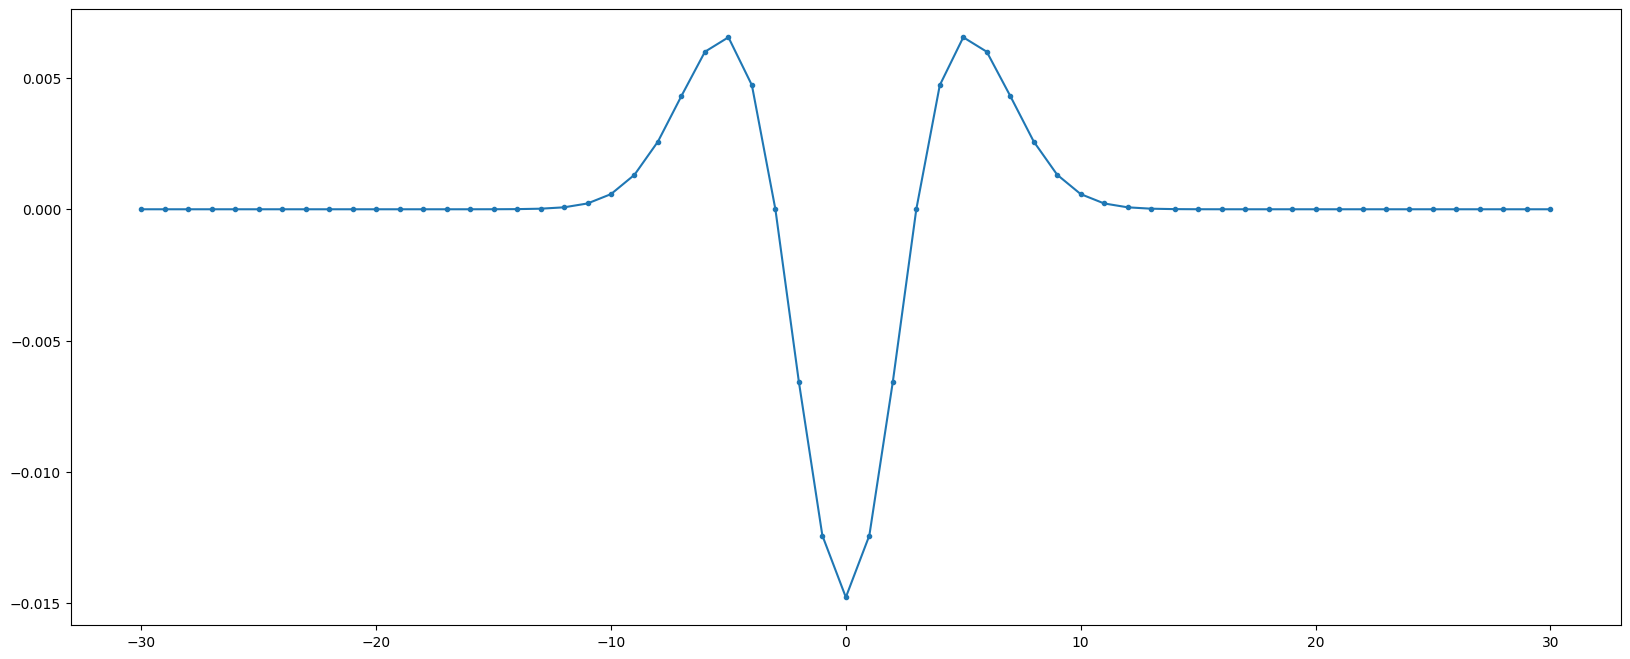

In [18]:
sigma = 3
filter_size = 10
Lx, x = laplace(sigma, filter_size)
plt.figure(1)
plt.plot(x, Lx, ".-")
plt.show()

#### **1.1.3: An example of non-linear filter: 1-D median filter**

Up until now we have worked with linear 1-D filters, you are now asked to implement a non-linear one: the 1-D median filter.
At each position $p$ of a given 1-D signal $\mathcal{S}$, the median filter of size $s$ takes the neighborhood $\mathcal{N}_s(p)=[\mathcal{S}(p - \frac{s - 1}{2}), \mathcal{S}(p + \frac{s - 1}{2})]$, and replaces the value of $p$ with the median of the values in $\mathcal{N}_s(p)$.
Since it removes outliers from $\mathcal{N}_s(p)$, the median filter is often used in image and signal processing to remove noise.

Complete the method below to compute the median filter $m(\cdot)$ of size $s$ for all elements of a signal $\mathcal{S}$.
The method should return the filtered signal.
From the description above, you may have noticed that one must *carefully* consider how to deal with the boundaries of the signal.
In this exercise, you are free to choose the strategy to deal with the boundaries, you may look [here](https://en.wikipedia.org/wiki/Median_filter).

You should get the following input-output pair:

![1dmedian](/content/drive/MyDrive/Homework01/images/1dmedian.png)

In [19]:
def median_filter(signal: np.ndarray, filter_size: int) -> np.ndarray:
    """
    Median 1D filter.
    You are free to choose how to deal with the beginning and the end of the signal.
    You can use the `np.median` function https://numpy.org/doc/stable/reference/generated/numpy.median.html

    Args:
        signal (np.ndarray): 1-D array of values
        filter_size (int): size of the filter

    Returns:
        signal (np.ndarray): 1-D array of values with the median values computed at each position
    """
    # Check for divisibility
    if filter_size % 2 == 0:
        filter_size -= 1  # Make it odd
#       raise ValueError("Filter size must be odd to have a center value.")

    filtered_signal = np.zeros_like(signal)

    # padding size
    pad_size = filter_size // 2

    # Pad the signal on both ends to handle boundary cases
    padded_signal = np.pad(signal, (pad_size, pad_size), mode='edge')

    # Apply the median filter
    for i in range(len(signal)):
        # Get the window around the current point (i)
        window = padded_signal[i:i + filter_size]

        # Compute the median of the window
        filtered_signal[i] = np.median(window)

    return filtered_signal

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

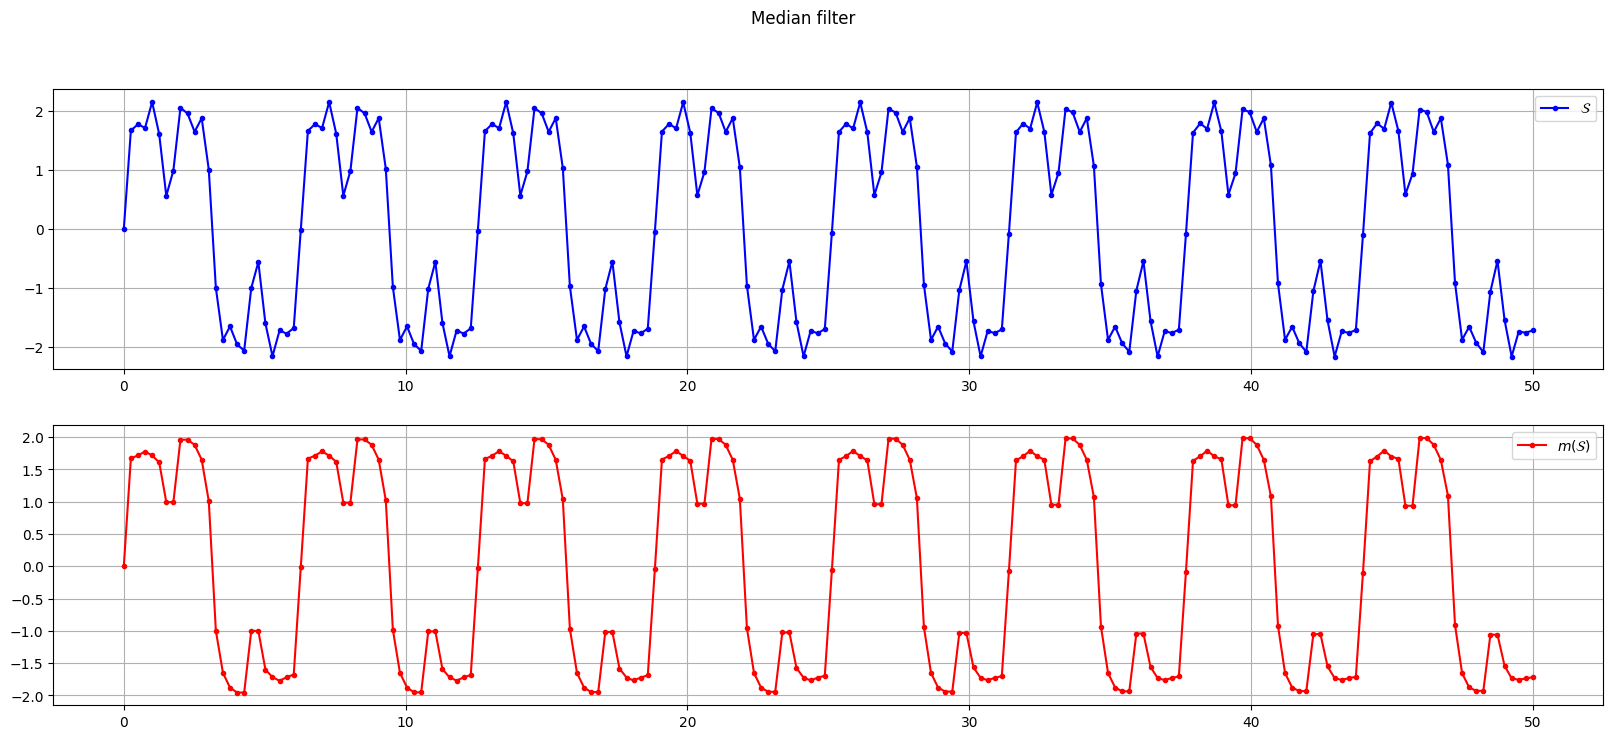

In [20]:
filter_size = 3 #each point in the signal is replaced by the median of its neighboring 3 values (the point itself and one value on each side).
signal = lambda x: 2 * np.sin(x) + np.sin(3 * x) + 0.5 * np.sin(7 * x)  # Example signal using a combination of sinusoidal functions
x = np.linspace(0, 50, 200)
in_signal = signal(x)
out_signal = median_filter(in_signal.copy(), filter_size)
fig, axs = plt.subplots(2)
fig.suptitle("Median filter")
axs[0].plot(x, in_signal, ".-", label="$\\mathcal{S}$", color="blue")
axs[0].grid()
axs[0].legend()
axs[1].plot(x, out_signal, ".-", label="$m(\\mathcal{S})$", color="red")
axs[1].grid()
axs[1].legend()
plt.show()

- Input signal generated is noisy.
- After applying the median filter it results to smooth out the higher-frequency fluctuations while preserving the overall shape of the signal.

Unlike linear filters like Gaussian filters, the median filter is non-linear


#### **1.1.4: Check linearity of the filters**

In *Question 1.0: warmup* we have seen some of the properties of linear operators and we have proven the additivity property of convolution.
Consider the 1-D Gaussian filter $g(\cdot)$, the 1-D Laplacian filter $l(\cdot)$, and the 1-D median filter $m(\cdot)$.
You are given signals $\mathcal{S}_1$ and $\mathcal{S}_2$, by taking advantage of the functions you have implemented in the previous exercises, empirically verify the following:

1. $g(\mathcal{S}_1 + \mathcal{S}_2) = g(\mathcal{S}_1) + g(\mathcal{S}_2)$
2. $l(\mathcal{S}_1 + \mathcal{S}_2) = l(\mathcal{S}_1) + l(\mathcal{S}_2)$
3. $g(l(\mathcal{S}_1 + \mathcal{S}_2)) = (g * l) * \mathcal{S}_1 + (g * l) * \mathcal{S}_2$
4. $m(\mathcal{S}_1 + \mathcal{S}_2) \neq m(\mathcal{S}_1) + m(\mathcal{S}_2)$

Can you explain why the median filter is not linear?

*HINT: you can exploit the function `convolve` from `scipy.signal` to compute the convolution with the Gaussian and the Laplacian filters.*

In [21]:
from scipy.signal import convolve
x = np.linspace(0, 50, 200)
s1 = 2 * np.sin(x) + np.sin(3 * x) + 0.5 * np.sin(7 * x)
s2 = 2 * np.cos(x) + np.cos(3 * x) + 0.5 * np.cos(7 * x)
sigma, filter_size = 1, 7

Gx = gauss(sigma, filter_size)[0]
g_s1 = convolve1d(s1, Gx, mode='constant')
g_s2 = convolve1d(s2, Gx, mode='constant')
g_s1_s2 = convolve1d(s1 + s2, Gx, mode='constant')
g_s1_g_s2 = g_s1 + g_s2
#print(x)

# Laplacian filter on signals
Lx, X = laplace(sigma, filter_size)
l_s1 = convolve1d(s1, Lx, mode='constant')
l_s2 = convolve1d(s2, Lx, mode='constant')
l_s1_s2 = convolve1d(s1 + s2, Lx, mode='constant')
l_s1_l_s2 = l_s1 + l_s2

# Gaussian + Laplacian combination on signals
g_l_s1_s2 = convolve1d(g_s1_s2, Lx, mode='constant')
g_l_s1_g_l_s2 = convolve1d(g_s1, Lx, mode='constant') + convolve1d(g_s2, Lx, mode='constant')

# Median filter on signals
m_s1 = median_filter(s1, filter_size)
m_s2 = median_filter(s2, filter_size)
m_s1_s2 = median_filter(s1 + s2, filter_size)
m_s1_m_s2 = m_s1 + m_s2

#g_s1_s2 = "YOUR CODE FOR THE FIRST TERM OF EQ.1"
#g_s1_g_s2 = "YOUR CODE FOR THE SECOND TERM OF EQ.1"
#l_s1_s2 = "YOUR CODE FOR THE FIRST TERM OF EQ.2"
#l_s1_l_s2 = "YOUR CODE FOR THE SECOND TERM OF EQ.2"
#g_l_s1_s2 = "YOUR CODE FOR THE FIRST TERM OF EQ.3"
#g_l_s1_g_l_s2 = "YOUR CODE FOR THE SECOND TERM OF EQ.3"
#m_s1_s2 = "YOUR CODE FOR THE FIRST TERM OF EQ.4"
#m_s1_m_s2 = "YOUR CODE FOR THE SECOND TERM OF EQ.4"

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [22]:
#np.allclose() checks if the two arrays are approximately equal within some tolerance. If they are not equal, it will raise an error message
assert np.allclose(g_s1_s2, g_s1_g_s2), "Equation (1) is not verified"
assert np.allclose(l_s1_s2, l_s1_l_s2), "Equation (2) is not verified"
assert np.allclose(g_l_s1_s2, g_l_s1_g_l_s2), "Equation (3) is not verified"
assert not np.allclose(m_s1_s2, m_s1_m_s2), "Equation (4) is not verified"

In [23]:
data = {'Name': ['g_s1_s2', 'g_s1_g_s2', 'l_s1_s2', 'l_s1_l_s2', 'g_l_s1_s2', 'g_l_s1_g_l_s2', 'm_s1_s2', 'm_s1_m_s2'],
        'Value': [g_s1_s2, g_s1_g_s2, l_s1_s2, l_s1_l_s2, g_l_s1_s2, g_l_s1_g_l_s2, m_s1_s2, m_s1_m_s2]}
df = pd.DataFrame(data)
df

Name                                              Value
0        g_s1_s2  [2.605329475051329, 3.4608516932142916, 3.2883...
1      g_s1_g_s2  [2.605329475051329, 3.460851693214291, 3.28830...
2        l_s1_s2  [-0.7848223039120834, -1.1450565047174353, -0....
3      l_s1_l_s2  [-0.7848223039120836, -1.1450565047174357, -0....
4      g_l_s1_s2  [-0.40283144317154584, -0.8462041538174168, -0...
5  g_l_s1_g_l_s2  [-0.40283144317154573, -0.8462041538174168, -0...
6        m_s1_s2  [3.5, 3.5, 3.1285541755961765, 2.8057218051071...
7      m_s1_m_s2  [3.5, 4.245694016316892, 3.023719291054218, 2....

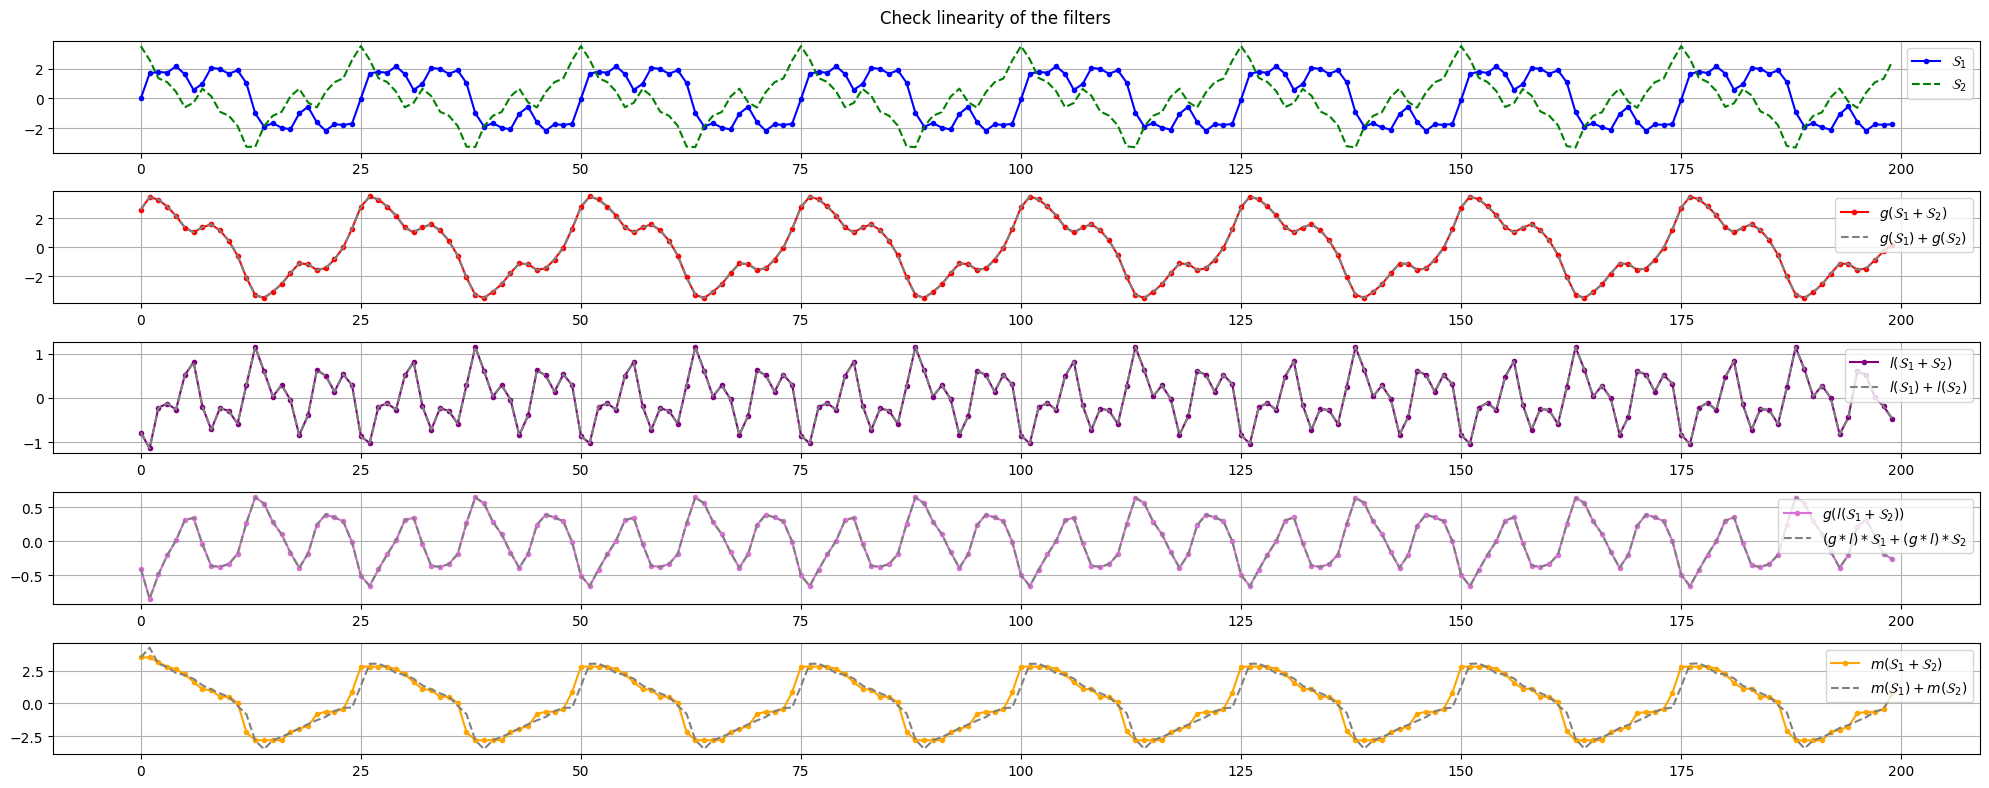

In [24]:
fig, axs = plt.subplots(5, 1)
fig.suptitle("Check linearity of the filters")
ys = [s1, s2, g_s1_s2, g_s1_g_s2, l_s1_s2, l_s1_l_s2, g_l_s1_s2, g_l_s1_g_l_s2, m_s1_s2, m_s1_m_s2]
labels = ["$\\mathcal{S}_1$", "$\\mathcal{S}_2$", "$g(\\mathcal{S}_1 + \\mathcal{S}_2)$", "$g(\\mathcal{S}_1) + g(\\mathcal{S}_2)$", "$l(\\mathcal{S}_1 + \\mathcal{S}_2)$", "$l(\\mathcal{S}_1) + l(\\mathcal{S}_2)$", "$g(l(\\mathcal{S}_1 + \\mathcal{S}_2))$", "$(g * l) * \\mathcal{S}_1 + (g * l) * \\mathcal{S}_2$", "$m(\\mathcal{S}_1 + \\mathcal{S}_2)$", "$m(\\mathcal{S}_1) + m(\\mathcal{S}_2)$"]
colors = ["blue", "green", "red", "gray", "purple", "gray", "orchid", "gray", "orange", "gray"]
for y_idx in range(0, len(ys), 2):
    i = y_idx // 2
    x = np.arange(ys[y_idx].shape[0])
    axs[i].plot(x, ys[y_idx], ".-", label=labels[y_idx], color=colors[y_idx])
    axs[i].plot(x, ys[y_idx + 1], "--", label=labels[y_idx + 1], color=colors[y_idx + 1])
    axs[i].grid()
    axs[i].legend(loc="upper right")
fig.tight_layout()
plt.show()

In the fifth row, where we apply the **median filter**, the two curves do not overlap perfectly, confirming is **non-linear** since it doesn't satisfy the property $m(S_1 + S_2) = m(S_1)+m(S_2)$

**Why this happen?** because it processes each signal sample by computing the median of a neighborhood of values. This operation is not additive, meaning the median of the sum of two signals is not equal to the sum of the medians of the individual signals

#### **1.1.5: Butterworth Filter**

The Butterworth filter is a type of frequency domain filter characterized by a smooth transition between passband and stopband.
    It is commonly used in signal processing to filter out frequencies beyond a certain cutoff, while maintaining a relatively flat frequency response in the passband.
    The sharpness of the cutoff is controlled by the order of the filter (n).

\begin{equation}
H(x) = \frac{1}{1 + \left( \frac{x}{\text{cutoff}} \right)^{2n}}
\end{equation}





With $\verb|cutoff|=20$ , $\verb|filtersize|=30$ and $n=2$ you shouls expect the following output:

![1dbutterworth](./images/Butterworth_Filter.png)

In [25]:
def butterworth_filter_1d(cutoff: float, filter_size: int, n: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Implements a 1D Butterworth filter.

    Args:
        cutoff (float): The frequency cutoff point. Determines the transition point between passband and stopband.
        filter_size (int): Size of the filter. The filter will have `filter_size` elements symmetrically centered around zero.
        n (int): The order of the Butterworth filter. Higher values result in a sharper transition between passband and stopband.
          when n=1, the filter has a smooth transition, and when n is larger, the transition becomes sharper.

    Returns:
        Hx (np.ndarray): The 1D Butterworth filter coefficients.
        x (np.ndarray): The x values corresponding to the filter, centered around zero.

    """
    # symmetric range of x values centered around zero
    x = np.linspace(-filter_size // 2, filter_size // 2, filter_size)

    Hx = 1 / (1 + (x / cutoff) ** (2 * n))

    return Hx, x


--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

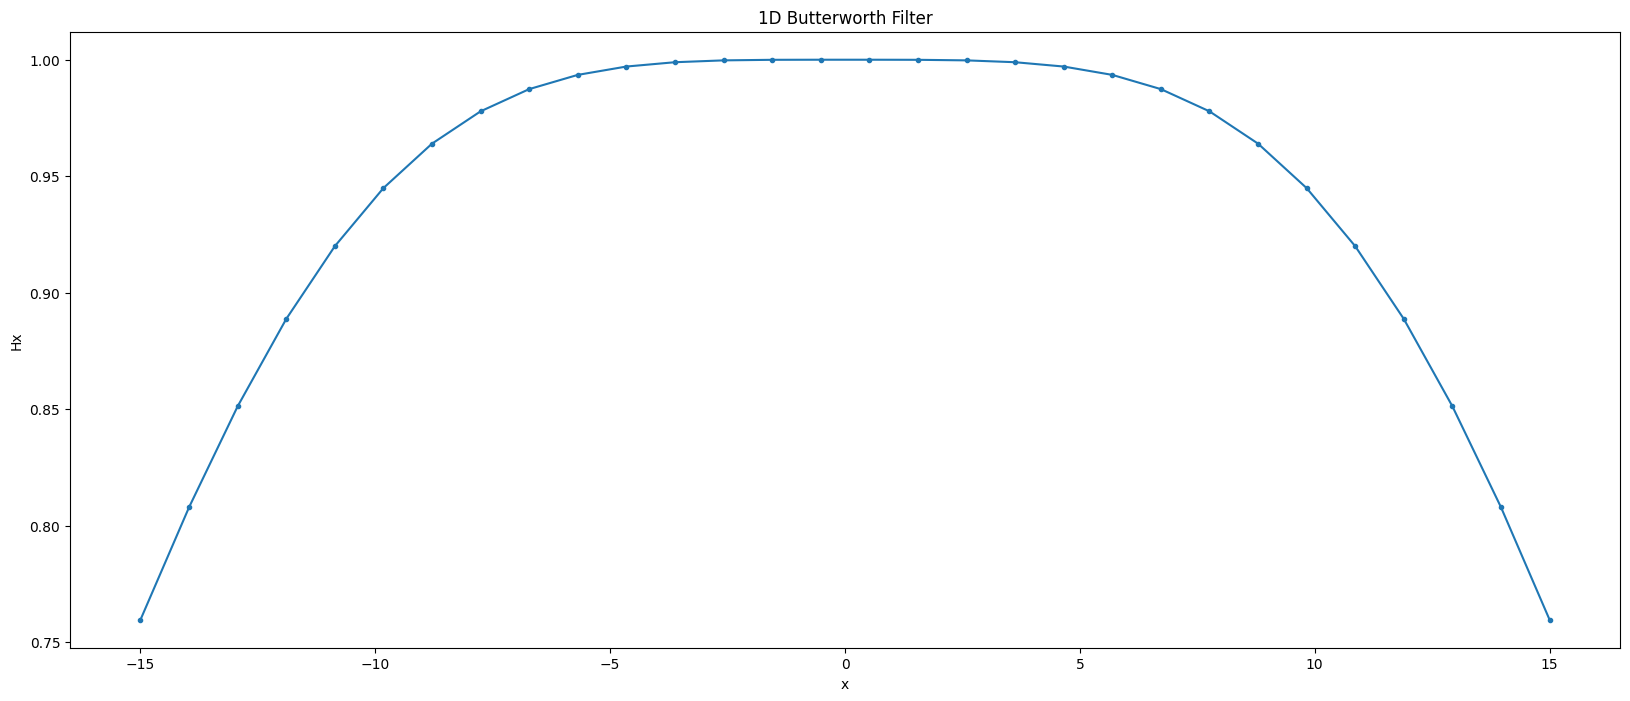

In [26]:
cutoff = 20.0
filter_size = 30
n = 2

# Generate the Butterworth filter
Hx, x = butterworth_filter_1d(cutoff, filter_size, n)

# Plot the Butterworth filter
plt.figure(1)
plt.plot(x, Hx, ".-")
plt.title("1D Butterworth Filter")
plt.xlabel("x")
plt.ylabel("Hx")
plt.show()

### **1.2: 2D Filters *(3 Points)***



##### **2-D Laplacian filter**

The function should take an image as input and return the result of the convolution of the image with a 2-D Laplacian kernel.
You can use Python’s `convolve2D` function if you don’t want to implement it yourself.

See the figure below for an illustration of Laplacian filtering.

![](./images/stella_laplace.jpg)

In [27]:
def laplacefiltering2D(img: np.ndarray, sigma: int, filter_size: int = 3) -> np.ndarray:
    """
    Implement a 2D Laplacian filter.

    Args:
        img (np.ndarray): Input image.
        sigma (int): Standard deviation.
        filter_size (int): Filter size.

    Returns:
        smooth_img (np.ndarray): Smoothed image.
    """
    # Calculate the Laplacian of the Gaussian kernel in 1D and then create the 2D kernel with outer product
    Lx = laplace(sigma, filter_size)[0]
    kernel_laplace = np.outer(Lx, Lx)

    smooth_img = convolve2d(img, kernel_laplace, mode="same", boundary="fill", fillvalue=0)

    return smooth_img


--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

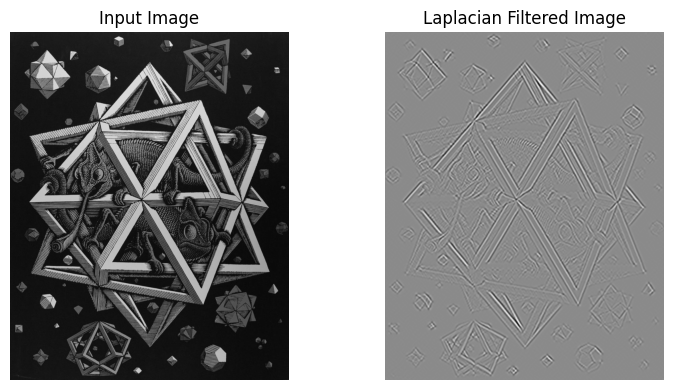

In [28]:
img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/stella.jpg")))
smooth_img = laplacefiltering2D(img, 3)

imgs = [img, smooth_img]
labels = ["Input Image", "Laplacian Filtered Image"]

plot_pictures(imgs, labels, nrows=1, ncols=2, cmap="gray", vmin=None, vmax=None)

##### **2-D Box filter**

The function should take an image as input and return the result of the convolution of this image with a 2D Box kernel.
Beware of errors in the following code, find them, and correct them.
You will be provided with the image to which the correct box filter has already been applied and you can use the SSIM metric to check that your result is correct, $SSIM \approx 1$ means that it is correct.

See the figure below for an illustration of Box filtering.

![](./images/box_image.jpg)

A box filter is essentially a matrix where all elements are equal, and their sum equals 1. For example:

$\text{Box Kernel} = \frac{1}{9} \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}$



In [29]:
def boxfiltering(img: np.ndarray, filter_size: int) -> np.ndarray:
    """
    Implement a 2D Box filter.

    Args:
        img (np.ndarray): Input image.
        filter_size (int): Filter size.

    Returns:
        smooth_img (np.ndarray): Smoothed image.

    """
    box_kernel = np.ones((filter_size, filter_size)) / (filter_size * filter_size)
    smooth_img = convolve2d(img, box_kernel, mode='same', boundary='fill', fillvalue=0)

    return smooth_img

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

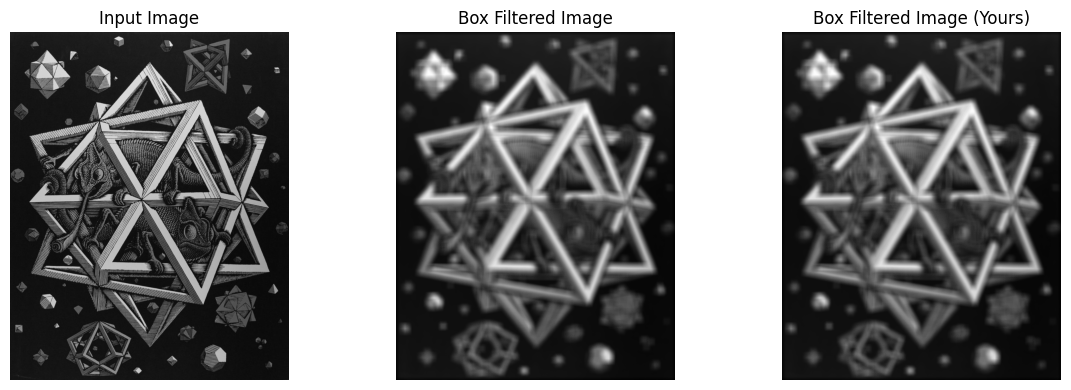

target_ssim_score:	1.0
your_ssim_score:	0.9999999999999889


In [30]:
img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/stella.jpg")))
smooth_img = np.load("/content/drive/MyDrive/Homework01/assets/box_filter.npy")
smooth_fooled = boxfiltering(img, 20)


imgs = [img, smooth_img, smooth_fooled]
labels = ["Input Image", "Box Filtered Image", "Box Filtered Image (Yours)"]

plot_pictures(imgs, labels, nrows=1, ncols=3, cmap="gray", vmin=None, vmax=None)

print(
    f"target_ssim_score:\t{ssim(smooth_img, smooth_img, data_range=smooth_img.max() - smooth_img.min())}\nyour_ssim_score:\t{ssim(smooth_img, smooth_fooled, data_range=smooth_img.max() - smooth_img.min())}"
)


##### **Separability and computational efficiency**

Analitically prove that the Laplacian filter is separable.

Recall that the Laplacian operator is defined as $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$.

-------------------------------------------------------


**WRITE YOU ANSWER HERE**


-------------------------------------------------------

### Proof that the Laplacian of the Gaussian is separable

#### 1. The Laplacian of the Gaussian

Given a 2D Gaussian function:
$$ g(x, y) = \frac{1}{2\pi\sigma^2} \exp\left( - \frac{x^2 + y^2}{2\sigma^2} \right) $$

The Laplacian operator is defined as:
$$ \nabla^2 g(x, y) = \frac{\partial^2 g(x, y)}{\partial x^2} + \frac{\partial^2 g(x, y)}{\partial y^2} $$

#### 2. Separable Property of the Gaussian

The 2D Gaussian function is separable, meaning that it can be factored into two 1D Gaussian functions:
$$ g(x, y) = g(x) \cdot g(y) $$
where
$$ g(x) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left( - \frac{x^2}{2\sigma^2} \right) $$
and
$$ g(y) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left( - \frac{y^2}{2\sigma^2} \right) $$

#### 3. Laplacian is Linear (Additivity Property)

The Laplacian operator, being linear, means that applying it to the product \( g(x, y) = g(x) \cdot g(y) \) can be broken into two parts:
$$ \nabla^2 g(x, y) = \nabla^2 g(x) + \nabla^2 g(y) $$

#### 4. Laplacian of Separable Components

For each of the components, we can compute the second derivatives with respect to \(x\) and \(y\):

- **Second derivative with respect to \(x\)**:
  $$ \frac{\partial^2 g(x)}{\partial x^2} = \frac{x^2 - \sigma^2}{\sigma^4} \cdot g(x) $$

- **Second derivative with respect to \(y\)**:
  $$ \frac{\partial^2 g(y)}{\partial y^2} = \frac{y^2 - \sigma^2}{\sigma^4} \cdot g(y) $$

#### 5. Full Laplacian of the Gaussian

Substituting these into the Laplacian equation:
$$ \nabla^2 g(x, y) = \left( \frac{x^2 - \sigma^2}{\sigma^4} \right) g(x) g(y) + \left( \frac{y^2 - \sigma^2}{\sigma^4} \right) g(x) g(y) $$

This simplifies to:
$$ \nabla^2 g(x, y) = g(x) g(y) \left( \frac{x^2 + y^2 - 2\sigma^2}{\sigma^4} \right) $$

#### 6. Conclusion: Separable Laplacian

Since the Laplacian of the Gaussian can be factored into products of 1D functions of \(x\) and \(y\), we conclude that:

**the Laplacian of the Gaussian is separable**.

Briefly explain why it is more convenient computationally speaking to use two 1D Laplacian filters rather than one 2D Laplacian filter.
Assume that the dimension of the 2D Laplacian filter is $k^2$ and that the dimension of the two 1D Laplacian filters is $k$.

-------------------------------------------------------


**WRITE YOU ANSWER HERE**


-------------------------------------------------------

### 2D Laplacian Filter:
A 2D filter of size
$k×k$ has $k^2$ elements.
### Two 1D Laplacian Filters:
Each 1D filter has k elements.
We apply two 1D filters (one along rows (x) and one along columns(y)), so it requires:
- k operations per row.
- k operations per columns

Thus, for each pixel in the image, applying two 1D filters requires 2k operations (one for rows and one for columns).
### Conclusion:
By using two 1D Laplacian filters instead of one 2D Laplacian filter, we reduce the computational complexity from $O(k^2)$ to $O(2k)$, which is significantly more efficient for large filter sizes.

##### **Practical example of separability**

Up to this point, we have seen that both the Gaussian and the Laplacian operators are linear and you have explicitly proven that the Laplacian operator is separable.
As you may guess, the Gaussian operator is also separable, and so is the composition of them: the Laplacian of Gaussian (LoG) operator.
Recall from section section "2-D Laplacian filter" that the LoG operator is defined as:

\begin{equation}
\nabla^2 \circ G = \frac{d^2G(x)}{dx^2}=-\frac{\sigma^2 - x^2}{\sqrt{2\pi}\sigma^5}\exp\left(-\frac{x^2}{2\sigma^2}\right)
\end{equation}

Previously, you have implemented a 2-D LoG filter without leveraging the separability property.
In this section, you're asked to implement again the 2-D LoG filter **exploiting the separability**, i.e. convolving the image with a separable 1-D Laplacian kernel along axes.

Compare the images to check that the separability property is valid. Note that the last image shows the differences between the separable case and the non separable case: it should be black up to numerical approximations, i.e. it should cointain approximately 0 everywhere.

In [31]:
from scipy.ndimage import convolve1d

def laplacefiltering(img: np.ndarray, sigma: int, filter_size: int = 3) -> np.ndarray:
    """
    Implement a 2D Laplacian filter using separability property.

    Args:
        img (np.ndarray): Input image.
        sigma (int): Standard deviation.
        filter_size (int): Filter size.

    Returns:
        derived_img (np.ndarray): Derived image after applying the LoG filter.
    """
    laplace_1d, _ = laplace(sigma, filter_size)
    # x axis
    laplace_img_x = convolve1d(img, laplace_1d, axis=0, mode='reflect')

    # y axis
    derived_img = convolve1d(laplace_img_x, laplace_1d, axis=1, mode='reflect')

    return derived_img

# Source https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

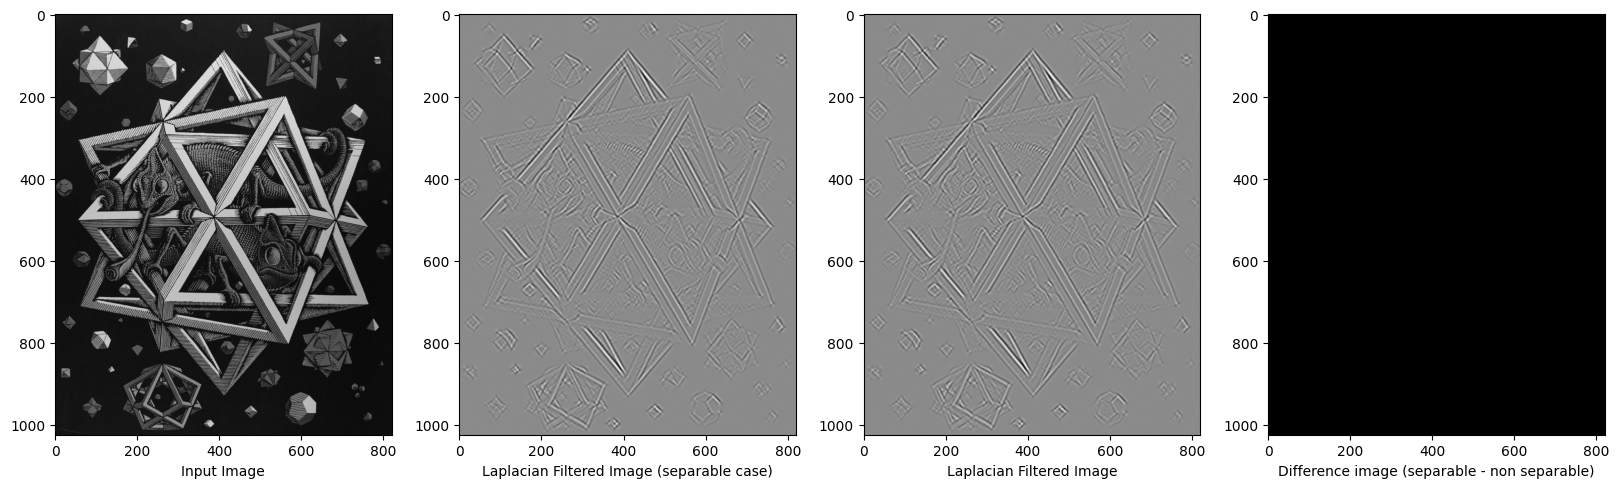

In [32]:
import time

img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/stella.jpg")))
t1 = time.perf_counter()
derived_img_separable = laplacefiltering(img, sigma=3)
t2 = time.perf_counter()
derived_img_non_separable = laplacefiltering2D(img, sigma=3)
t3 = time.perf_counter()
difference_img = derived_img_separable - derived_img_non_separable

plt.figure(2)
ax1 = plt.subplot(1, 4, 1)
ax1.set_xlabel("Input Image")
ax2 = plt.subplot(1, 4, 2)
ax2.set_xlabel("Laplacian Filtered Image (separable case)")
ax3 = plt.subplot(1, 4, 3)
ax3.set_xlabel("Laplacian Filtered Image")
ax4 = plt.subplot(1, 4, 4)
ax4.set_xlabel("Difference image (separable - non separable)")


plt.sca(ax1)
plt.imshow(img, cmap="gray")
plt.sca(ax2)
plt.imshow(derived_img_separable, cmap="gray")
plt.sca(ax3)
plt.imshow(derived_img_non_separable, cmap="gray")
plt.sca(ax4)
plt.imshow(difference_img * 100, cmap="gray", vmin=0, vmax=255)
plt.show()

assert ssim(derived_img_separable, derived_img_non_separable, data_range=derived_img_separable.max() - derived_img_separable.min()) > 0.999, "The separable and non-separable Laplacian filters are not the same."

In [33]:
print(derived_img_separable.max() - derived_img_separable.min())

1.002762021881202


In [34]:
# Emperically speaking: let's compare computation time of separable and non-separable laplace filtering
print(f"Computational time of separable laplace filtering: {t2 - t1:0.4f} seconds")
print(f"Computational time of non-separable laplace filtering: {t3 - t2:0.4f} seconds")

Computational time of separable laplace filtering: 0.0280 seconds
Computational time of non-separable laplace filtering: 0.8409 seconds


##### **Gaussian Blur Filter**

Implement a 2D Gaussian filter.
Make it so that the filter size changes adaptively with the size of sigma, and round it up to the nearest odd integer.
$$
\verb|filter_size| = \lceil 3\sigma \rceil
$$

See the figure below for an illustration of the blurring filter:

![](./images/moon_gauss.jpg)

In [35]:
def gaussfiltering(img: np.ndarray, sigma: int) -> np.ndarray:
    """
    Implement a 2D Gaussian filter, leveraging the previous gauss.

    Args:
        img (np.ndarray): Input image.
        sigma (int): Standard deviation.

    Returns:
        smooth_img (np.ndarray): Smoothed image.
    """
    filter_size = int(np.ceil(6 * sigma))
    Gx = gauss(sigma, filter_size)[0]
    kernel_gauss = np.outer(Gx, Gx)

    smooth_img = convolve2d(img, kernel_gauss, mode="same", boundary="fill", fillvalue=0)

    return smooth_img



--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [36]:
'''
img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/moon.jpg")))
imgs = [img, gaussfiltering(img, 10)]
labels = ["Input Image", "Harris Corner Detector Image"]
plot_pictures(imgs, labels, nrows=1, ncols=2, cmap="gray", vmin=0, vmax=255)
# computational expensive?? ETA
'''
#too much time to run

'\nimg = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/moon.jpg")))\nimgs = [img, gaussfiltering(img, 10)]\nlabels = ["Input Image", "Harris Corner Detector Image"]\nplot_pictures(imgs, labels, nrows=1, ncols=2, cmap="gray", vmin=0, vmax=255)\n# computational expensive?? ETA\n'

#### **Discrete Laplacian Operator**

Write the [discrete Laplacian filter](https://en.wikipedia.org/wiki/Discrete_Laplace_operator), which is a discrete approximation of the Laplacian Filter, speciic for image processing.

Now, given an image $x$, a Gaussian filter $G(x)$ and a discrete Laplacian filter $L(x)$, compute:
- $ G(L(x)) $
- $ L(G(x)) $

And check that the $SSIM = 1$

See the figure below for illustration of the discrete Laplacian:

![](./images/laplacian.png)

In [37]:
def discrete_laplace(img: np.ndarray) -> np.ndarray:
    """
    Discrete Laplacian operator.

    Args:
        img (np.ndarray): Input image.

    Returns:
        Lap (np.ndarray): Image after applying the Laplacian operator.
    """

    laplacian_kernel = np.array([[0, -1, 0],
                                 [-1, 4, -1],
                                 [0, -1, 0]])

    Lap = convolve(img, laplacian_kernel)
    return Lap

img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/lenna.jpg")))
sigma = 1 #int
print(f"Original image shape: {img.shape}, dtype: {img.dtype}")
#image_edges = "YOUR CODE HERE"
image_edges = discrete_laplace(img)
print(f"Laplacian image shape: {image_edges.shape}, dtype: {image_edges.dtype}")
#image_edges_smoothed = "YOUR CODE HERE"
image_edges_smoothed = gaussfiltering(image_edges, sigma)
print(f"Smoothed Laplacian edges shape: {image_edges_smoothed.shape}, dtype: {image_edges_smoothed.dtype}")
#image_smoothed = "YOUR CODE HERE"
image_smoothed = gaussfiltering(img, sigma)
print(f"Smoothed image shape using Gauss: {image_smoothed.shape}, dtype: {image_smoothed.dtype}")
#image_smoothed_edges = "YOUR CODE HERE"
image_smoothed_edges = discrete_laplace(image_smoothed)
print(f"Image after Laplacian on smoothed image shape: {image_smoothed_edges.shape}, dtype: {image_smoothed_edges.dtype}")

Original image shape: (512, 512), dtype: float64
Laplacian image shape: (514, 514), dtype: float64
Smoothed Laplacian edges shape: (514, 514), dtype: float64
Smoothed image shape using Gauss: (512, 512), dtype: float64
Image after Laplacian on smoothed image shape: (514, 514), dtype: float64


--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

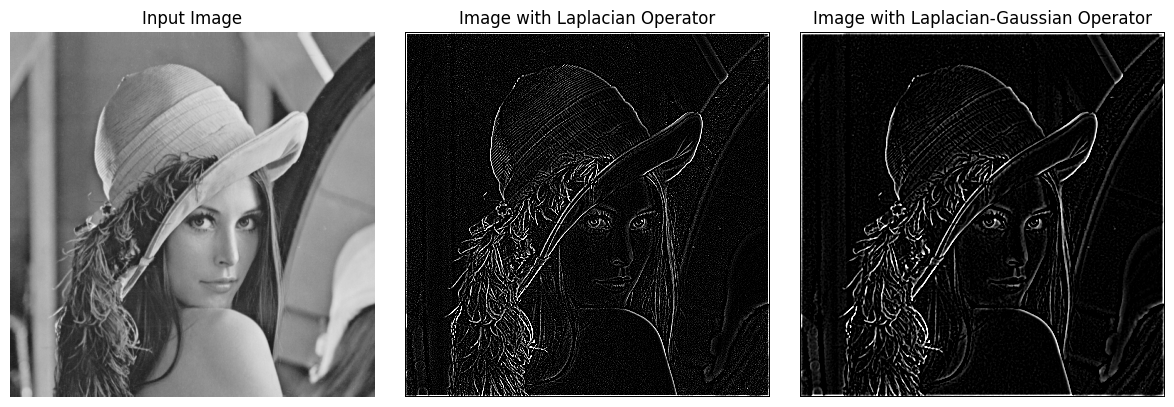

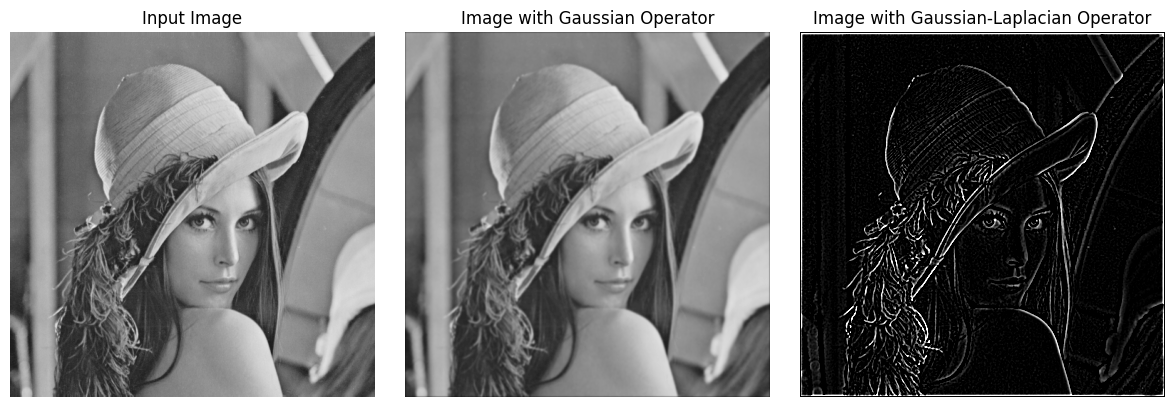

In [38]:
# LoG
imgs = [img, image_edges*5, image_edges_smoothed*10]
labels = [
    "Input Image",
    "Image with Laplacian Operator",
    "Image with Laplacian-Gaussian Operator",
]
plot_pictures(imgs, labels, nrows=1, ncols=3, cmap="gray", vmin=0, vmax=255)

# GoL
imgs = [img, image_smoothed, image_smoothed_edges*10]
labels = [
    "Input Image",
    "Image with Gaussian Operator",
    "Image with Gaussian-Laplacian Operator",
]
plot_pictures(imgs, labels, nrows=1, ncols=3, cmap="gray", vmin=0, vmax=255)


assert ssim(
            image_edges_smoothed,
            image_smoothed_edges,
            data_range=image_edges_smoothed.max() - image_edges_smoothed.min(),
        ) > 0.9, "The LoG and GoL operators should have similar results."


## **Question 2: Multi-Scale Image Representations** *(9 Points)*

Edges represents object boundaries, thus edge detection is a very important preprocessing step for any object detection or recognition process.
Simple edge detection kernels are based on approximation of gradient images.

You will use some basic edge detection kernels.

### **2.1: Prewitt Operator** *(2 points)*
The [Prewitt operator](https://en.wikipedia.org/wiki/Prewitt_operator) is used in image processing, particularly within edge detection algorithms.
Technically, it is a discrete differentiation operator, computing an approximation of the gradient of the image intensity function.

See figure below for illustration of Prewitt operators in action:

<img src="https://upload.wikimedia.org/wikipedia/commons/3/3f/Bikesgray.jpg" width="300"/> <img src="https://upload.wikimedia.org/wikipedia/commons/3/3e/Bikesgray_prewitt.JPG" width="300"/>

Now implement the Prewitt operators. Try to take advantage of the separability of this filter.

In [39]:
def prewitt_x(img: np.ndarray) -> np.ndarray:
    """
    Implement a 3x3 Prewitt discrete operator for vertical edges.

    Args:
        img (np.ndarray): Input image.

    Returns:
        Fx (np.ndarray): Image with vertical edges.
    """

    # Define the Prewitt kernel for vertical edges
    kernel_x = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

    Fx = convolve2d(img, kernel_x)

    return Fx


def prewitt_y(img: np.ndarray) -> np.ndarray:
    """
    Implement a 3x3 Prewitt discrete operator for horizontal edges.

    Args:
        img (np.ndarray): Input image.

    Returns:
        Fx (np.ndarray): Image with horizontal edges.
    """
    kernel_y = np.array([[1, 1, 1],
                   [0, 0, 0],
                   [-1, -1, -1]])

    Fy = convolve2d(img, kernel_y)
    return Fy

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

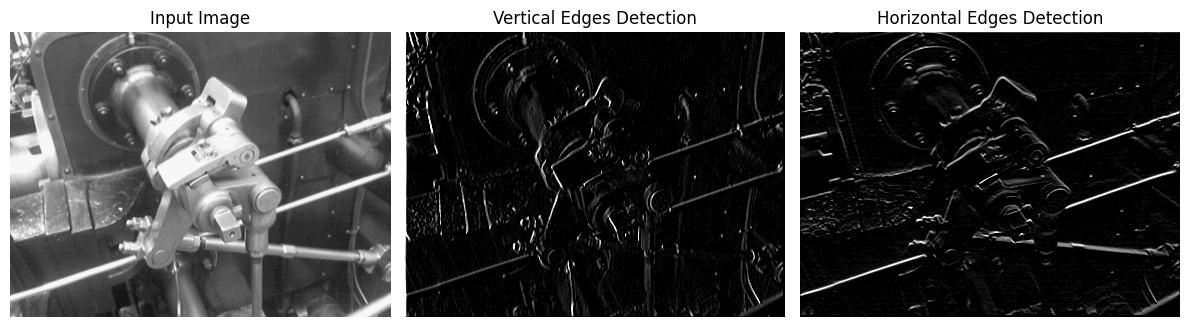

In [40]:
img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/valve.png")))
imgs = [img, prewitt_x(img), prewitt_y(img)]
labels = ["Input Image", "Vertical Edges Detection", "Horizontal Edges Detection"]
plot_pictures(imgs, labels, nrows=1, ncols=3, cmap="gray", vmin=0, vmax=255)

#### Gradient Magnitude
Using the previously defined functions `prewitt_x` and `prewitt_y`, retrieve the gradient magnitude of the image.

See the figure below for an illustration of the Gradient Magnitude:

![](./images/sobel.png)

In [41]:
def gradient_magnitude(img: np.ndarray) -> np.ndarray:
    """
    Apply the Prewitt operator to the image and compute
    the gradient magnitude.

    Args:
        img (np.ndarray): Input image.

    Returns:
        magnitude (np.ndarray): Gradient magnitude.
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
		# filtered_image(i+1, j+1) = sqrt(Gx.^2 + Gy.^2);
    # Source: wikipedia
    magnitude = np.sqrt(prewitt_x(img)**2 + prewitt_y(img)**2)

    return magnitude

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

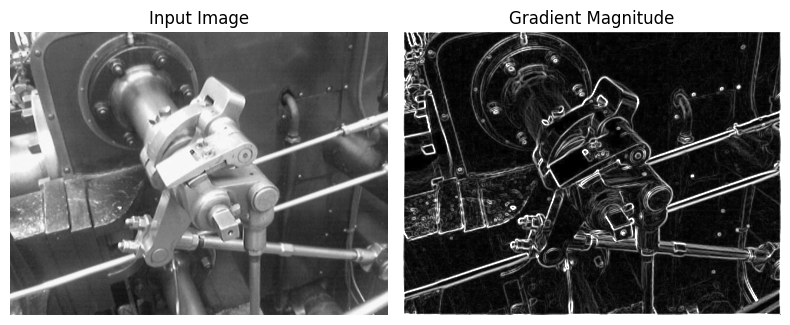

In [42]:
img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/valve.png")))
igms = [img, gradient_magnitude(img)]
labels = ["Input Image", "Gradient Magnitude"]
plot_pictures(igms, labels, nrows=1, ncols=2, cmap="gray", vmin=0, vmax=255)

### **2.2 Canny Edge Detector and Template Matching** *(3 points)*
The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images.

The Canny edge detection algorithm is composed of 5 steps:

1. Noise reduction: apply Gaussian filter to smooth the image in order to remove the noise
2. Gradient calculation: find the intensity gradients of the image
3. Non-maximum suppression: apply gradient magnitude thresholding or lower bound cut-off suppression to get rid of spurious response to edge detection
4. Double threshold: apply double threshold to determine potential edges
5. Edge Tracking by Hysteresis: track edge by hysteresis: finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.


You can learn more about the Canny edge detector at the following links:
- [Canny Edge Detection](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html).
- [Canny Edge Detection Step by Step in Python — Computer Vision](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123).
- [What is a Canny Edge Detection Algorithm?](https://towardsai.net/p/computer-vision/what-is-a-canny-edge-detection-algorithm).

##### **Stage 1** - *Noise reduction*

Apply Gaussian filter to smooth the image in order to remove the noise.
**You just need to run the code for this stage**.

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

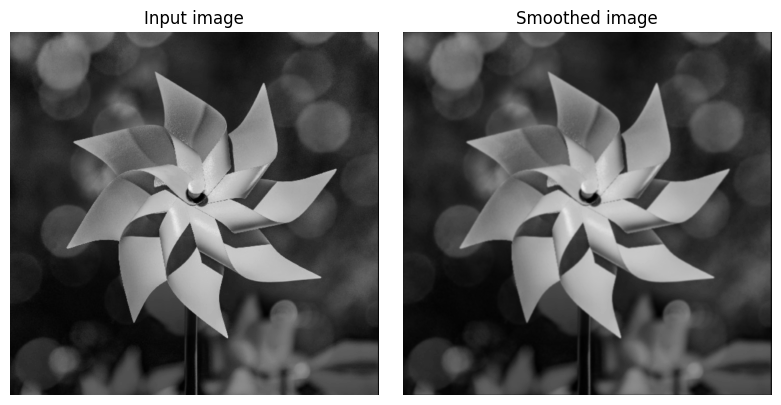

In [43]:
# STEP 1:
img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/pinwheel.jpg")))
smoothed_img = gaussfiltering(img, sigma=1)

plot_pictures([img, smoothed_img], ["Input image", "Smoothed image"], 1, 2, vmax=255)

##### **Stage 2** - *Gradient calculation*

This step detects edges intensity and direction by calculating the gradient of the image through edge detection operators.

Edges correspond to a change of pixels’ intensity, the easiest way to detect it is applying filters that highlight it in both directions: horizontal ($x$) and vertical ($y$).

When the image is smoothed, the derivatives $D_x(I)$ and $D_y(I)$ w.r.t. $x$ and $y$ are calculated.
It can be implemented by convolving $I$ with Prewitt kernels $K_x$ and $K_y$, respectively.

Taking advantage of the functions `prewitt_x` and `prewitt_y` you have previously implemented, compute the gradient magnitude and direction of the image.
Your function will output the magnitude $G$ and the slope $\theta$ of the gradient.
Scale the magnitude to the range $[0,255]$.

In [44]:
# STEP 2
def prewitt_filters(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function applies the prewitt filter to the input image in x and y direction.
    Scale' the magnitude to [0, 255] and return the magnitude and the direction of the gradient.

    Args:
        img (np.ndarray): input image

    Returns:
        G (np.ndarray): gradient magnitude
        theta (np.ndarray): gradient direction
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    Kx = prewitt_x(img)
    Ky = prewitt_y(img)

    G = gradient_magnitude(img)

    theta = np.arctan2(Ky, Kx)
    return (G, theta)
  # Source https://www.cse.psu.edu/~rtc12/CSE486/lecture05_6pp.pdf

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

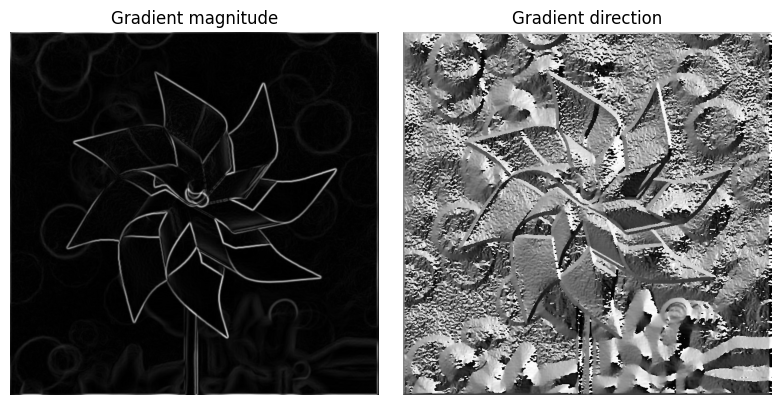

In [45]:
G, theta = prewitt_filters(smoothed_img)

plot_pictures([G, theta], ["Gradient magnitude", "Gradient direction"], 1, 2)

##### **Stage 3** - *Non-maximum suppression*

The image is scanned along the image gradient direction and, if pixels are not part of the local maxima, they are set to zero.
This has the effect of suppressing all image information that is not part of local maxima.

In [46]:
def direction_scan(
    img: np.ndarray, theta: float, i:int, j:int
    ) -> List[float]:
    """
    This function quantizes the gradient directions into
    four discrete directions:
        - horizontal: theta in [0, 22.5) or [157.5, 180]
        - right diagonal: theta in [22.5, 67.5)
        - vertical: theta in [67.5, 112.5)
        - left diagonal: theta in [112.5, 157.5)
    then it returns the pixel values of the two pixels in
    the corresponding direction.

    Returns:
        neighbors List[float]: pixel values of the two neighbors
            in the corresponding direction
    """
    #####################################################
    ##            FIX THIS CODE (8 ERRORS)             ##
    ##       7 - fix angles        ##
    #####################################################
    # angle 0: theta in [0, 22.5) or [157.5, 180]
    if (0 <= theta[i,j] < 22.5) or (157.5 <= theta[i,j] <= 180):
        neighbors = [(i, j+1), (i, j-1)]
    # angle 45: theta in [22.5, 67.5)
    elif (22.5 <= theta[i,j] < 67.5):
        neighbors = [(i+1, j+1), (i-1, j-1)]
    # angle 90: theta in [67.5, 112.5)
    elif (67.5 <= theta[i,j] < 112.5):
        neighbors = [(i+1, j), (i-1, j)]
    #angle 135: theta in [112.5, 157.5)
    else:
        neighbors = [(i+1, j-1), (i-1, j+1)]

    N, M = img.shape
    pixels = [img[x,y] for x, y in neighbors if 0 <= x < N and 0 <= y < M]
    return pixels

def non_max_suppression(img: np.ndarray, D: np.ndarray) -> np.ndarray:
    """
    This function performs non-maximum suppression on the input image.

    Args:
        img (np.ndarray): input image
        D (np.ndarray): gradient direction

    Returns:
        Z (np.ndarray): image after non-maximum suppression
    """

    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.uint8)

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            #####################################################
            ##                 YOUR CODE HERE                  ##
            #####################################################
            pixels = direction_scan(img, D, i, j)
            if img[i,j] >= max(pixels):
                Z[i,j] = img[i,j]

    return (Z / Z.max() * 255).astype(np.uint8)


--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

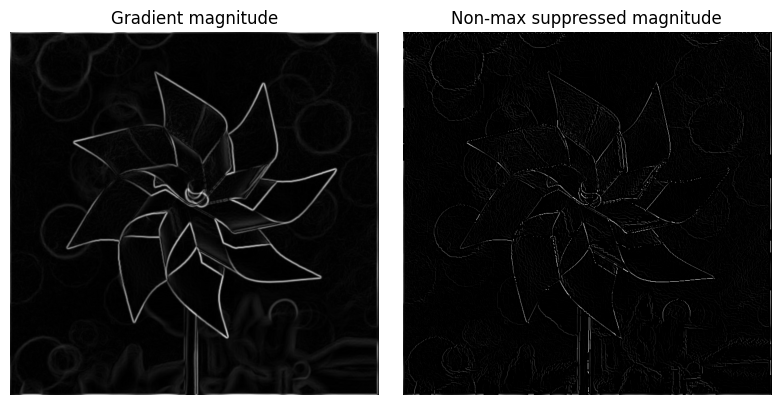

In [47]:
Z = non_max_suppression(G, theta)

plot_pictures(
    [G, Z*2],
    ["Gradient magnitude", "Non-max suppressed magnitude"],
    1,
    2,
)

My solution doesn't work for some reason, @vic does

##### **Stage 4** - *Thresholding*

After application of non-maximum suppression, remaining edge pixels provide a more accurate representation of real edges in an image.
However, some edge pixels remain that are caused by noise and color variation.
To account for these spurious responses, it is essential to filter out edge pixels with a weak gradient value and preserve edge pixels with a high gradient value.

This is accomplished by selecting high and low threshold values:
- If an edge pixel’s gradient value is higher than the high threshold value, it is marked as a strong edge pixel.
- If an edge pixel’s gradient value is smaller than the high threshold value and larger than the low threshold value, it is marked as a weak edge pixel.
- If an edge pixel's gradient value is smaller than the low threshold value, it will be suppressed.

Implement the function `threshold` that takes as input the image, the low and high threshold ratios and returns a tuple whose elements are the thresholded image, the value of the weak edges and the value of the strong edges. Set the value of weak edges to 100 and the value of strong edges to 255.

In [48]:
# STEP 4
def threshold(
    img: np.ndarray,
    low_threshold: int = 100, high_threshold: int = 200,
    weak_value :int = 100, strong_value: int = 255
) -> np.ndarray:
    """
    This function applies a double thresholding to the input image.

    Args:
        img (np.ndarray): input image
        low_threshold (int): low threshold
        high_threshold (int): high threshold
        weak_value (int): value for weak edges
        strong_value (int): value for strong edges

    Returns:
        res (np.ndarray): thresholded image
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    i_height, i_width = img.shape
    res = np.zeros((i_height, i_width), dtype=np.uint8)

    # Retrive only strong and weak pixels, non-relevent are non-relevant for the
    # edge and won't be analysed in the Hysteresis mechanism
    strong_i, strong_j = np.where(img >= high_threshold)
    weak_i, weak_j = np.where((img <= high_threshold) & (img >= low_threshold))

    res[strong_i, strong_j] = strong_value
    res[weak_i, weak_j] = weak_value

    return res

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

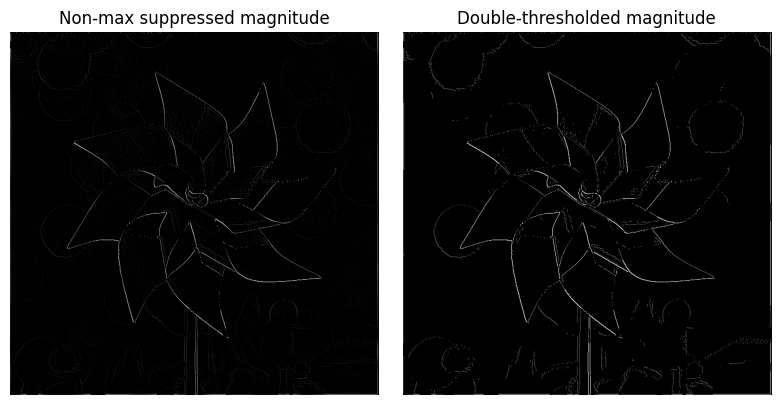

In [49]:
weak_value = 100
strong_value = 255
res = threshold(Z, low_threshold=25, high_threshold=100, weak_value=weak_value, strong_value=strong_value)

plot_pictures(
    [Z, res],
    ["Non-max suppressed magnitude", "Double-thresholded magnitude"],
    1,
    2,
)

##### **Stage 5** - *Hysteresis*

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one.

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [50]:
# STEP 5
def hysteresis(img: np.ndarray, weak: int = 100, strong: int = 255) -> np.ndarray:
    """
    This function applies hysteresis to the input image.

    Args:
        img (np.mdarray): input image.
        weak (int): weak threshold.
        strong (int): strong threshold.

    Returns:
        img (np.ndarray): image after hysteresis.
    """
    M, N = img.shape
    img_ = img.copy()
    strong_edges_idxs = np.argwhere(img == strong).tolist()
    while len(strong_edges_idxs) > 0:
        i, j = strong_edges_idxs.pop()
        if (i - 1 >= 0) and (j - 1 >= 0) and (i + 1 < M) and (j + 1 < N):
            weak_edges_mask = img_[i - 1 : i + 2, j - 1 : j + 2] == weak
            if np.any(weak_edges_mask):
                img_[i - 1 : i + 2, j - 1 : j + 2][weak_edges_mask] = strong
                weak_edges_idxs = (
                    (np.argwhere(weak_edges_mask) - 1) + np.array([i, j])
                ).tolist()
                strong_edges_idxs = strong_edges_idxs + weak_edges_idxs[::-1]
    img_[img_ != strong] = 0
    return img_

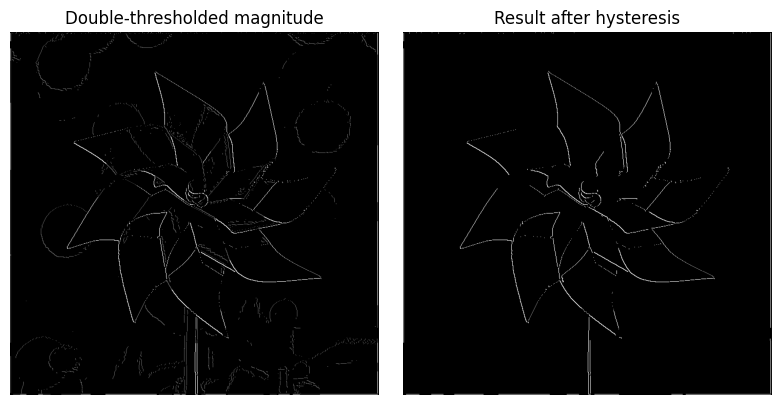

In [51]:
final_img = hysteresis(res, weak=weak_value)

plot_pictures(
    [res, final_img],
    ["Double-thresholded magnitude", "Result after hysteresis"],
    1,
    2,
)


##### **Wrap up**
Once you have seen how the Canny edge detector works step by step, implement the following `canny_edge_detector` function that wraps all the previous steps and returns the final image.

In [52]:
def canny_edge_detector(
    img: np.ndarray, sigma: int = 1,
    low_threshold: int = 50, high_threshold: int = 100
) -> np.ndarray:
    """
    This function implements the Canny edge detector.
    Put together the previous functions to implement the
    Canny edge detector.
    Don't apply the gaussian filter if sigma=0.

    Args:
        img (np.ndarray): input image
        sigma (int): standard deviation for the gaussian filter;
            if sigma=0, no gaussian filter is applied
        low_threshold (int): low threshold
        high_threshold (int): high threshold

    Returns:
        out_img (np.ndarray): image after applying the Canny edge
            detector
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    weak_value = 100

    # STEP 1: gaussian smoothing if sigma > 0
    img = gaussfiltering(img, sigma) if sigma != 0 else img

    # STEP 2: applying image gradient
    G, theta = prewitt_filters(img)

    # STEP 3: non-maximum suppression
    Z = non_max_suppression(G, theta)

    # STEP 4: thresholding
    res = threshold(Z, low_threshold=low_threshold, high_threshold=high_threshold, weak_value=weak_value)

    # STEP 5: Hysteresis
    out_img = hysteresis(res, weak=weak_value)

    return out_img

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

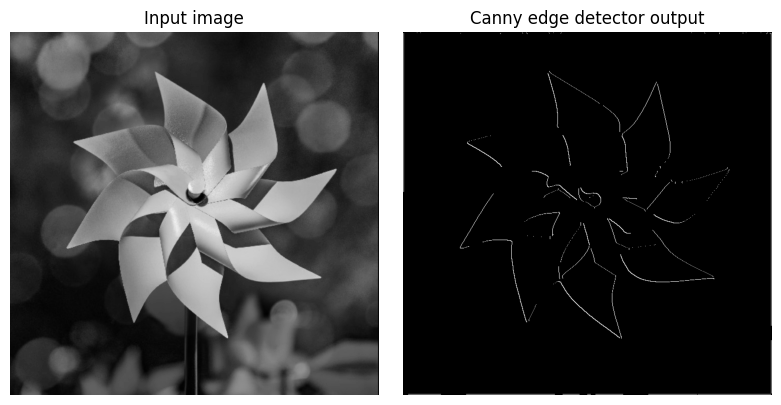

In [53]:
img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/pinwheel.jpg")))
out_img = canny_edge_detector(img, sigma=2, low_threshold=35, high_threshold=100)

plot_pictures(
    [img, out_img],
    ["Input image", "Canny edge detector output"],
    1,
    2,
)

manca lo stelo, a @vic va

#### **2.4.1: Template matching**

In this section, you are going to implement a template matching algorithm.
The goal of template matching is to find the patch in the image that is most similar to a given template.
In this exercise, you are going to use the Canny edge detector to extract the edges of the image and the template.
Then, you will find the patch in the image that is most similar to the template.
To choose the patch, you are asked to implement the [Jaccard Similarity](https://en.wikipedia.org/wiki/Jaccard_index) metric:
\begin{equation}
\mathrm{Jaccard}(I_{ij}, T)
= \frac{|I_{ij} \cap T|}{|I_{ij} \cup T|}
%= \frac{\verb|sum|(I_{ij} \land T)}{\verb|sum|(I_{ij} \lor T)}
\end{equation}

In practice we can compute this by computing the ratio between the number of pixels where both $T$ and $I_{ij}$ have an edge and the number of pixels where $T$ or $I_{ij}$ have an edge.
Note that $T$ denotes the template image, $I$ the target image, $I_{ij}$ a patch of $I$ at position $ij$ having the same dimensions of $T$.

Implement the following function that takes as input the target image $I$, and the template image $T$. The returned values are a matrix of shape `(i_height-t_heigh, i_width-t_width)` containing the metric scores at each position and the indexes $(i,j)$ of the patch in $I$ with the best metric value, as depicted below. Note that $i$ indexes along the height of $I$, $j$ indexes along the width of $I$.

```
(i,j)-------width--------+
  |                      |
  |                      |
height                   |
  |                      |
  |                      |
  +----------------------+
```

In [54]:
def jaccard(patch:np.ndarray,template:np.ndarray) -> float:
    """
    This function computes the Jaccard similarity between
    two images.

    Args:
        patch (np.array): patch of the input image
        template (np.array): template to match

    Returns:
        jaccard_score (float)
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    intersection = np.logical_and(patch, template)
    union = np.logical_or(patch, template)
    jaccard_score = np.sum(intersection) / np.sum(union)

    return jaccard_score

def match_template(
    img: np.ndarray, template: np.ndarray
) -> Tuple[np.ndarray, Tuple[int, int]]:
    """
    This function implements the template matching algorithm.

    Args:
        img (np.ndarray): input image.
        template (np.array): template to match.

    Returns:
        img_score (np.ndarray): metric scores after applying the template matching algorithm.
        best_match_idxs (tuple): index of the best match.
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    t_height, t_width = template.shape
    i_height, i_width = img.shape
    assert (i_height >= t_height) and (i_width >= t_width), f"Cannot match template of shape {template.shape} with image of shape {img.shape}"
    # Stores Jaccard similarities
    img_score = np.zeros((i_height - t_height + 1, i_width - t_width + 1))

    # Iterate through the image to calculate Jaccard scores for each patch
    for i in range(i_height - t_height + 1):
        for j in range(i_width - t_width + 1):
            patch = img[i:i + t_height, j:j + t_width]
            img_score[i, j] = jaccard(patch, template)

    # Find linear index of the best match and converts it back into 2D index
    best_match_idxs = np.unravel_index(np.argmax(img_score), img_score.shape)

    return img_score, best_match_idxs

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

*Note: by running the following code, you should be able to detect the bigger Wally.*

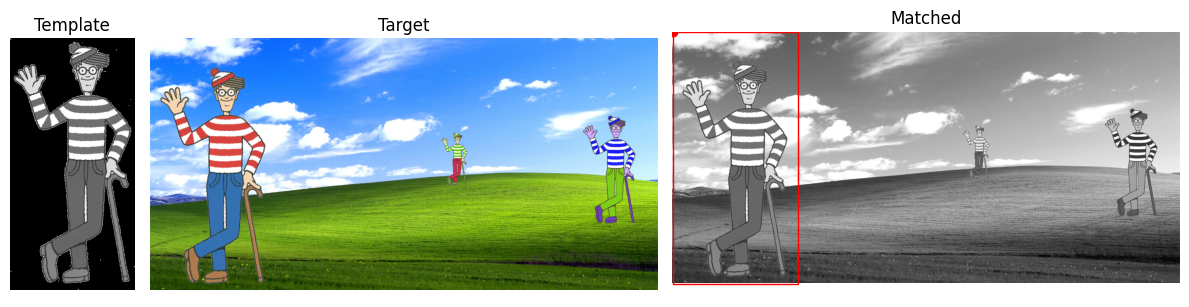

In [55]:
import matplotlib.patches as patches

img_1 = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/wally.jpg")))
img_2 = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/findwally.jpg")))

template = canny_edge_detector(img_1, sigma=1.5, low_threshold=40, high_threshold=100)
target = canny_edge_detector(img_2, sigma=1, low_threshold=25, high_threshold=100)

imgs = [img_1, np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/findwally.jpg")), img_2]
xlabels = ["Template", "Target", "Matched"]
axs = plot_pictures(imgs, xlabels, 1, 3, show=False, vmin=None, vmax=None)
img_score, best_match = match_template(target, template)

axs[-1].plot(best_match[1], best_match[0], "ro")
axs[-1].add_patch(
    patches.Rectangle(
        (best_match[1], best_match[0]),
        template.shape[1],
        template.shape[0],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
)

plt.show()

Here you can look at the template and at target image side by side, after having applied the Canny edge detector.
Notice how they are different even though the parameters of the Canny edge detector are the same: this is due to the images not having the same background.

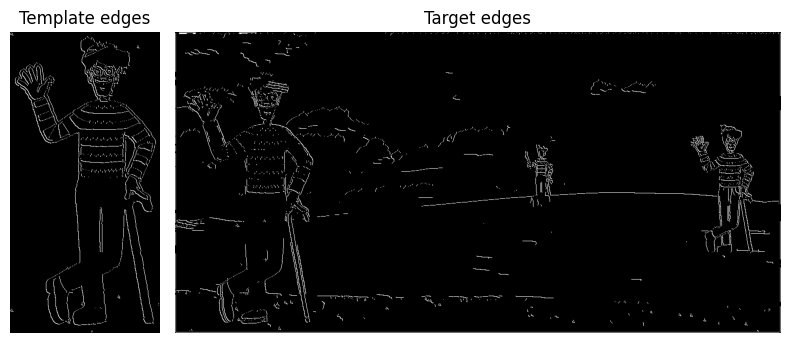

In [56]:
imgs = [template, target]
xlabels = ["Template edges", "Target edges"]
plot_pictures(imgs, xlabels, 1, 2, show=True, cmap="gray", same_scale=True)

### **2.3 Harris Corner Detector** ( points)

The Harris Corner Detector is a feature detection method used in computer vision to find corners, which are points with significant intensity changes in multiple directions. It works by analyzing image gradients to identify regions where shifting a small window results in large intensity variations.

It can be considered a variation of the Canny Edge Detector. Implement it by leveraging the previously implemented functions.

For more information: [link](https://en.wikipedia.org/wiki/Harris_corner_detector)

In [57]:
def harris_corner_detector(
    img: np.ndarray,
    sigma: float = 1,
    k: float = 0.04,
    threshold: float = 1e-2) -> np.ndarray:
    """
    Harris Corner Detector.

    Args:
        img (np.ndarray): Input grayscale image.
        sigma (float): Standard deviation for Gaussian smoothing.
        k (float): Sensitivity factor to separate corners from edges.
        threshold (float): Threshold for detecting corners.

    Returns:
        corners (np.ndarray): Image with corners marked.
    """
    #####################################################
    ##              COMPLETE THIS CODE                 ##
    #####################################################
    # Step 1: Smooth the image
    img = gaussfiltering(img, sigma) if sigma != 0 else img

    # Step 2: Compute the gradients
    dx, dy = prewitt_x(img), prewitt_y(img)
    dx2 = dx**2
    dxy = dx*dy
    dy2 = dy**2

    # Step 3: Compute the sums of the products of gradients
    window = np.ones((3, 3))
    Sxx = convolve2d(dx2, window, mode='same')
    Sxy = convolve2d(dxy, window, mode='same')
    Syy = convolve2d(dy2, window, mode='same')

    # Step 4: Compute the determinant and trace of the Harris matrix
    det = (Sxx * Syy) - (Sxy**2)
    trace = Sxx + Syy

    # Step 5: Compute the Harris response
    R = det - k * (trace**2)

    corners = np.zeros_like(img)
    # thresholding
    corners[R > threshold * np.max(R)] = 255
    return corners

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [58]:
img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/pinwheel.jpg")))
imgs = [img, harris_corner_detector(img, 1)]
labels = ["Input Image", "Harris Corner Detector Image"]
plot_pictures(imgs, labels, nrows=1, ncols=2, cmap="grey", vmin=0, vmax=255)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 706 but corresponding boolean dimension is 708

[testo del link](https://)### **2.4 Gaussian Pyramid** *(2 points)*

Now let's implement a multi-scale object detection algorithm with Gaussian pyramid and template matching.

**Gaussian Pyramid**

Implement a downscaling function that makes use of the iterative approach described by the Gaussian Pyramid. Use [`skimage.transform.resize`](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize) to resize the image to a lower scale, but don't forget to first smooth the image.
Repeat this process `step` times.

In [ ]:
def downscale(
    img: np.ndarray,
    factor: float,
    steps:int=3,
    sigma:float=1
    ) -> np.ndarray:
    """
    Iteratively apply a gaussian blur to avoid aliasing
    and then downscale the input image by the given factor.

    Args:
        img (np.ndarray): Input image.
        factor (float): Resizing factor, how may times smaller
            is the image going to be.
        steps(int): the number of times to repeat the iteration.
        sigma (float): Standard deviation for the Gaussian filter.

    Returns:
        imgs (list): list of downscaled images. Each one is
            "factor" times smaller then the previous.
        blurred (list): list of blurred images produced in
            the downscaling process.
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    imgs = [img]
    blurred = [gaussfiltering(img, sigma)]
    for _ in range(steps):
        # Apply Gaussian blur to avoid aliasing
        blurred_img = gaussfiltering(imgs[-1], sigma)
        blurred.append(blurred_img)

        # Downscale the image
        new_height = int(imgs[-1].shape[0] / factor)
        new_width = int(imgs[-1].shape[1] / factor)
        img_resized = resize(blurred_img, (new_height, new_width))

        # Append the downscaled image
        imgs.append(img_resized)

    return imgs, blurred


In [ ]:
'''
img = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/coffee.jpg")))
STEPS = 3
imgs, img_blur = downscale(img, 2, steps=STEPS, sigma=3)

for i in range(STEPS+1):
    fig, axes = plt.subplots(1, 2, figsize=(int(12* .8**(i+1)),int(8* .8**(i+1))))
    plt.gray()
    fig.tight_layout()
    axes[0].imshow(imgs[i])
    axes[0].set_title(f"Resized image {imgs[i].shape}" if i != 0 else "Original Image")
    axes[0].axis('off')
    if i < STEPS:
        axes[1].imshow(img_blur[i])
        axes[1].set_title(f"Smooth image {img_blur[i].shape}")
    axes[1].axis('off')
'''

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

##### **Aliasing**

When an image is downscaled, some information is inevitably lost. If this process isn't handled carefully, it can lead to distortions such as jagged edges, moiré patterns, or a "stair-step" effect on diagonal lines. This kind of effect is called "Aliasing".

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2F1.bp.blogspot.com%2F-AWQvtxVtBBY%2FV9F03wJwAnI%2FAAAAAAAAA7A%2FVfGtkgT8O60Y9jBx5hXT1ixw4URaqxHWQCLcB%2Fs1600%2FSupersampling%252B2D%252Banti-aliasing.gif&f=1&nofb=1&ipt=0de5f53f14ec430997ea1d210e4f6ab6bcb5131861fe84ddeeb14e15be689527&ipo=images)

These artifacts arise because the sampling rate of the new, smaller image is insufficient to accurately represent the high frequency details present in the original image. This is related to the Nyquist-Shannon sampling theorem, which states that to accurately represent a signal, the sampling rate must be at least twice the highest frequency present in the signal.
To mitigate aliasing when downscaling, various techniques can be employed, such as applying low-pass filters before reducing the image size (i.e. a Gaussian blur).

Now confront the results of downscaling with the gaussian pyramid that you just implemented against a naive resizing.

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

I had to change the code section cause the solution provided above works only for grayscale img (2D arrays), instead the input given in the next block cell is a colored img

In [ ]:
def downscale_color(
    img: np.ndarray,
    factor: float,
    steps: int = 3,
    sigma: float = 1
) -> np.ndarray:
    """
    Same downscale function but handles color images by applying
    Gaussian blur and downscaling to each channel separately.
    """
    # Split the image into R, G, B channels
    channels = [img[:, :, i] for i in range(img.shape[-1])]

    imgs_channels = []
    blurred_channels = []

    # Apply Gaussian blur and downscale for each channel
    for channel in channels:
        imgs, blurred = downscale(channel, factor, steps, sigma)
        imgs_channels.append(imgs)
        blurred_channels.append(blurred)

    # Merge the channels back together after downscaling and blurring
    downsampled_imgs = [np.stack(ch, axis=-1) for ch in zip(*imgs_channels)]
    blurred_imgs = [np.stack(ch, axis=-1) for ch in zip(*blurred_channels)]

    return downsampled_imgs, blurred_imgs


In [ ]:
img = np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/bricks.jpg"))
img_no_blur = np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/bricks.jpg"))

imgs, img_blur = downscale_color(img, 2, steps=3, sigma=1)


for i in range(3):
    img = imgs[i+1]
    img_no_blur = resize(img_no_blur, (img_no_blur.shape[0] //2, img_no_blur.shape[1] // 2))

    fig, axes = plt.subplots(1, 2, figsize=(int(12* .75**(i+1)),int(8* .8**(i+1))))
    plt.gray()
    fig.tight_layout()
    axes[0].imshow(img.astype(int))
    axes[0].set_title(f"Downsampled image {img.shape[:2]}\nwith Anti-aliasing")
    axes[0].axis('off')
    axes[1].imshow(img_no_blur)
    axes[1].set_title(f"Downsampled image {img_no_blur.shape[:2]}\nwithout blurring")
    axes[1].axis('off')
    plt.show()

**QUESTION**

Which differences do you notice between the first and the second image?
What is the cause of the Aliasing effect?

-------------------------------------------------------


**WRITE YOU ANSWER HERE**


-------------------------------------------------------

**First Image (Downscaled to 378x311):**
The anti-aliased version is smooth and free from distortions, while the version without blurring shows slight jagged edges and early signs of aliasing. The image details are still somewhat clear

**Second Image (189x155):**
The anti-aliased image appears softer, losing some brick texture details but remains artifact-free. In contrast, the image without blurring displays pronounced aliasing effects, including jagged lines and moiré patterns, distorting the brick pattern.

**Third Image (94x77):**
The anti-aliased image is blurred with minimal detail, ensuring no aliasing is present. The image without blurring, however, shows severe aliasing, with distorted brick patterns and significant pixelation, making the structure appear misrepresented.

Aliasing happens when you shrink an image without smoothing it first. When you make an image smaller, it has to fit a lot of details into fewer pixels. If you don’t blur the image first (using Gaussian blur for instance), the details can get messy, causing weird patterns, jagged edges, or distorted lines. This happens because the small image can't properly show all the fine details of the bigger image.

By blurring the image before shrinking it, you remove those fine details that the smaller image can't handle, which keeps everything looking smooth and clean.




### **2.5: Multi-Scale Template Matching (? Points)**
Write a multi-scale object detection algorithm using the Gaussian Pyramid and the template matching algorithm you have implemented in the previous exercise.

In [ ]:
def multi_scale_match_template(
    img: np.ndarray,
    template: np.ndarray,
    steps: int,
    sigma: float = 1,
    low_threshold: int = 30,
    high_threshold: int = 70,
) -> List[Dict[str, Union[np.ndarray, Tuple[int, int]]]]:
    """
    This function implements the multi-scale template matching.

    Args:
        img (np.ndarray): input image.
        template (np.ndarray): template image.
        steps (int): number of steps for the Pyramid.
        sigma (float): the Gaussian filter parameter.
        low_threshold (int): low threshold for Canny edge detector.
        high_threshold (int): high threshold for Canny edge detector.

    Returns:
        out: list of dictionaries containing:
            img_score (np.ndarray): score image.
            result (Tuple[int, int]): best match coordinates.
            template (np.ndarray): template image.
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    # Define target
    target = canny_edge_detector(img, sigma=sigma, low_threshold=low_threshold, high_threshold=low_threshold)
    # Downscale templates
    templates = downscale(template, factor=2, steps=steps, sigma=sigma)[0]

    # Calculate metric scores after applying the template matching algorithm and index of the best match
    score_results = [
        match_template(
            target,
            canny_edge_detector(t, sigma=sigma, low_threshold=low_threshold, high_threshold=low_threshold)
            )
        for t in templates]

    out = [
        {"img_score": score, "result": result, "template": t}
        for (score, result), t in zip(score_results, templates)
    ]

    return out



_____________________________________________________
**Do not write below this line just run it**
_____________________________________________________



In [ ]:
img1 = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/findwally.jpg")))
img2 = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/wally.jpg")))

multiscale_res = multi_scale_match_template(
    img=img1,
    template=img2,
    steps=2,
    sigma=1,
    low_threshold=30,
    high_threshold=70,
)


imgs = [img2, np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/findwally.jpg"))]
xlabels = [
    "Template",
    "Matched",
]
axs = plot_pictures(imgs, xlabels, 1, 2, show=False, vmin=None, vmax=None)

for d in multiscale_res:
    axs[-1].plot(d["result"][1], d["result"][0], "ro")
    axs[-1].add_patch(
        patches.Rectangle(
            (d["result"][1], d["result"][0]),
            d["template"].shape[1]-2,
            d["template"].shape[0]-2,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
    )
plt.show()

## **Question 3: Object Identification** *(12 Points)*

*Note: This identification part contains **query and model images** for the evaluation, which correspond to the same set of objects photographed from different viewpoints. The files **model.txt** and **query.txt** contain lists of image files arranged so that i-th model image depicts the same object as i-th query image.*

#### **3.1: 3D Joint Color Histogram** *(2 points)*

Your task is to implement a Python function, histogramdd, from scratch. This function should compute the multidimensional histogram of a given image. The function should accept an image and a specification for the number of bins to use for each dimension. You should then divide the data into bins and count the number of data points that fall into each bin.

If you want to check that your result is correct, you can compare it with the [function already implemented by NumPy](https://numpy.org/doc/stable/reference/generated/numpy.histogramdd.html).

In [59]:
def histogramdd(img: np.ndarray, bins: int = 10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Follow these steps:
        1) Create bin intervals for each dimension.
        2) Compute the shape of the histogram based on bin intervals.
        3) Initialize the histogram as an array of zeros.
        4) Compute the histogram for the input data.

    Args:
        img (np.ndarray): Input image.
        bins (int): Number of bins.

    Returns:
        histograms (np.ndarray): Histogram.
        bin_edges (np.ndarray): Bin edges.
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################


    bin_edges = np.linspace(0, 256, bins + 1)

    # Prepare the 3D histogram
    histogram = np.zeros((bins, bins, bins), dtype=int)

    # Normalize and flatten image data
    img_flat = img.reshape(-1, 3)

    # Determine the bin for each R, G, B value
    r_bin = np.digitize(img_flat[:, 0], bin_edges) - 1
    g_bin = np.digitize(img_flat[:, 1], bin_edges) - 1
    b_bin = np.digitize(img_flat[:, 2], bin_edges) - 1

    # Update histogram based on RGB bin positions
    for r, g, b in zip(r_bin, g_bin, b_bin):
        if 0 <= r < bins and 0 <= g < bins and 0 <= b < bins:
            histogram[r, g, b] += 1

    # Controllo suggerito dal testo
    # histogram, edges = np.histogramdd(img.reshape(-1, 3), bins=(bins, bins, bins), range=((0, 256), (0, 256), (0, 256)))

    # Restituisci l'istogramma e i bordi dei bin
    return histogram, [bin_edges, bin_edges, bin_edges]


In [ ]:
# Check
image = np.random.random((100, 3)) * 256
hist, edges = histogramdd(image, bins=10)
np_hist, np_edges = np.histogramdd(image, bins=(10, 10, 10), range=((0, 256), (0, 256), (0, 256)))

print(np.array_equal(hist, np_hist))

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

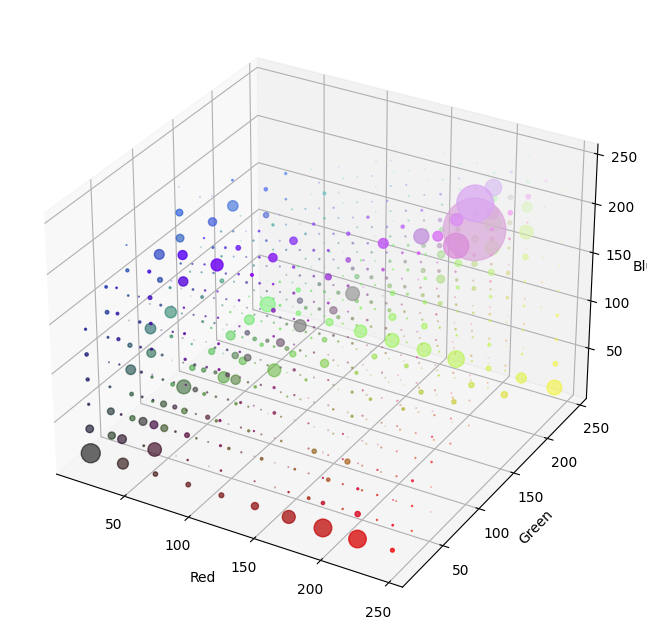

In [60]:
def histogram3dplot(h, e, fig=None):
    """
    Visualize a 3D histogram

    Parameters
    ----------

    h: histogram array of shape (M,N,O)
    e: list of bin edge arrays (for R, G and B)
    """
    M, N, O = h.shape  # numero di bins
    idxR = np.arange(M)
    idxG = np.arange(N)
    idxB = np.arange(O)

    R, G, B = np.meshgrid(idxR, idxG, idxB)  # divisione per bins
    a = np.diff(e[0])[0]
    b = a / 2
    R = a * R + b

    a = np.diff(e[1])[0]
    b = a / 2
    G = a * G + b

    a = np.diff(e[2])[0]
    b = a / 2
    B = a * B + b

    colors = np.vstack((R.flatten(), G.flatten(), B.flatten())).T / 255
    h = h / np.sum(h)
    if fig is not None:
        f = plt.figure(fig)
    else:
        f = plt.gcf()
    ax = f.add_subplot(111, projection="3d")
    mxbins = np.array([M, N, O]).max()
    ax.scatter(
        R.flatten(),
        G.flatten(),
        B.flatten(),
        s=h.flatten() * (256 / mxbins) ** 3 / 2,
        c=colors,
    )

    ax.set_xlabel("Red")
    ax.set_ylabel("Green")
    ax.set_zlabel("Blue")


img = Image.open("/content/drive/MyDrive/Homework01/assets/images/colors.jpg")
img = np.array(img)
h, e = histogramdd(img.reshape(-1, 3), bins=10)
histogram3dplot(h, e)

#### **3.2: Types of Histograms** *(2 points)*

In this section, you are asked to implement the **GB** histogram and to correct the dx/dy histogram. Finally, you are asked to comment and compare the results.

##### **GB Histogram**

In this exercise, you should implement the **GB** histogram.

*Note: as before, when considering GB, you should keep in mind that the range of the pixel's intensity is between $0$ and $255$*.

In [61]:
def gb_hist(img_color_double: np.ndarray, num_bins: int = 5) -> np.ndarray:
    """
    Compute the *joint* histogram for the G and B color channels in the image.
    The histogram should be normalized so that sum of all values equals 1,
    assume that values in each channel vary between 0 and 255

    Args:
        img_color_double (np.ndarray): Input color image.
        num_bins (int): Number of bins used to discretize each channel, total number of bins in the histogram should be num_bins^2.

    Returns:
        hists (np.ndarray): Joint histogram.

    E.g. hists[0,9] contains the number of image_color pixels such that:
        - their G values fall in bin 0
        - their B values fall in bin 9
    """

    # Estrarre i canali Verde (G) e Blu (B)
    G = img_color_double[:, :, 1]  # Canale G
    B = img_color_double[:, :, 2]  # Canale B

    bin_edges = np.linspace(0, 256, num_bins + 1)

    # Prepara l'array per l'istogramma 2D
    hists = np.zeros((num_bins, num_bins), dtype=int)

    # Determina in quale bin cade ciascun valore di G e B per ogni pixel
    g_bin = np.digitize(G.flatten(), bin_edges) - 1
    b_bin = np.digitize(B.flatten(), bin_edges) - 1

    # Itera su tutti i pixel e aggiorna l'istogramma 2D
    for g, b in zip(g_bin, b_bin):
      if 0 <= g < num_bins and 0 <= b < num_bins:
         hists[g, b] += 1

    hists = hists / np.sum(hists)
    hists= hists.flatten()

    return hists

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [ ]:
# Compose and test GB histograms (histogram_module.GB_hist)
img_color = np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/superman.jpg"))

plt.figure(3, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_color)

num_bins_color = 5
plt.subplot(1, 2, 2)
hist_gb = gb_hist(img_color.astype("double"), num_bins_color)
plt.bar(np.array(range(1, hist_gb.size + 1)), hist_gb)
plt.show()

##### **DX/DY Histogram**

In this exercise, you will find an implemented version of another type of histogram, the dx/dy one. However, **it is not correct, there are some mistakes in the code**:

- function `gaussdx`: **2 mistakes**;
- function `gauss_dxdy`: **2 mistakes**;
- function `hist_dxdy`: **2 mistakes**.

You are asked to copy each function in the corresponding cell and to correct the mistakes. Put a comment on the lines where you have made the corrections.
Before coding, write down the first derivative of the Gaussian function.

*HINT: leverage the result of the derivation to correct the mistakes in `gaussdx`*.

*Note: each mistaken line counts as one mistake; a mistake can also be a missing line or a missing block of lines*.

-------------------------------------------------------


**WRITE YOU ANSWER HERE**


-------------------------------------------------------

$$
\begin{align}
\frac{d}{dx}g(x) &= \frac{d}{dx}\left[\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{x^2}{2\sigma^2}\right)\right] = \\
&= \text{YOUR ANSWER HERE}
\end{align}
$$

In [62]:
def gaussdx(sigma: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function computes the first derivative of the 1D Gaussian operator.

    Args:
        sigma (float) : the standard deviation of the Gaussian filter

    Returns:
        Dx (np.ndarray): the first derivative of the 1D Gaussian operator
        x (np.ndarray): the indexes of the 1D Gaussian operator
    """
    #sigma = math.ceil(sigma)
    # Filter_size should represent the number of points used for the filter,
    # which is an integer. The width of the filter should cover the range [-3 * sigma, 3 * sigma].
    # The size should be 2 * (3 * sigma) + 1, but since we need an integer we use np.ceil() to round up
    # for ensureing that the filter width fits this range => filter_size = 2 * np.ceil(3 * sigma) + 1.
    #filter_size = 3 * sigma + 1
    filter_size = 2 * (3 * sigma) + 1


    # Generate the index x
    # The calculation of zero_pos is incorrect.
    # It attempts to position the zero point, but the formula 3 * filter_size is a misunderstanding of the index positions.
    # zero_pos should be at the midpoint of the filter. It should be filter_size // 2.
    #zero_pos = 3 * filter_size  # the (zero_pos+1)th element is the 0 for the index
    zero_pos = filter_size // 2  # the (zero_pos+1)th element is the 0 for the index
    x = np.arange(filter_size) - zero_pos  # indexes from -3*sigma to 3*sigma

    # Compute the Gaussian curve with std-dev sigma at the indexes x
    # Following the derivate calculated before we should add a "-" before x
    # Dx = x * np.exp(-(x**2) / (2.0 * sigma**2)) / (math.sqrt(2.0 * np.pi) * sigma)
    Dx = -x * np.exp(-(x**2) / (2.0 * sigma**2)) / (math.sqrt(2.0 * np.pi) * sigma**3)


    return Dx, x


--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

To check that your implementation is correct, plot the result of the function with $\sigma=3$ and compare it with the image below.

![](./images/1gaussdx.png)

In [ ]:
# plot the first derivative of the 1D Gaussian operator
sigma = 3
Dx, x = gaussdx(sigma)
plt.figure(1)
plt.plot(x, Dx, ".-")
plt.show()

_____________________________________________________

In [63]:
def gauss_dxdy(img: np.ndarray, sigma: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function applies the first derivative of the 1D Gaussian operator to the image in the x and y directions.

    Args:
        img (np.ndarray): the input image.
        sigma (float): the standard deviation of the Gaussian filter.

    Returns:
        img_Dx (np.ndarray): the image after applying the first derivative of the 1D Gaussian operator in the x direction.
        img_Dy (np.ndarray): the image after applying the first derivative of the 1D Gaussian operator in the y direction.
    """
    #####################################################
    ##                 FIX THIS CODE                   ##
    #####################################################
    Gx, _ = gauss(sigma, filter_size=6*sigma)
    Dx, _ = gaussdx(sigma)

    #The convolution on the image using convolve1d
    #it's being applied in a nested way (convolve1d(convolve1d(...))).
    #Since convolve1d only applies convolution in one direction,
    #we need to ensure that the convolutions are applied separately along the x and y axes.

    #The convolve1d function likely expects the filter/kernel to be applied first and then the image
    #or there may be confusion with the order of axes.

    # img_Dx = convolve1d(convolve1d(img, Dx), Gx)
    # img_Dy = convolve1d(convolve1d(img, Gx), Dx)
    img_Dx = convolve1d(img, Dx, axis=1)
    img_Dx = convolve1d(img_Dx, Gx, axis=0)

    img_Dy = convolve1d(img, Dx, axis=0)
    img_Dy = convolve1d(img_Dy, Gx, axis=1)

    return img_Dx, img_Dy


--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

To check that your implementation is correct, plot the result of the function with $\sigma=1$ and compare it with the images below.

![](./images/check_gaussdxdy.png)

In [ ]:
img_color = rgb2gray(np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/pinwheel.jpg")))

img_Dx, img_Dy = gauss_dxdy(img_color, 1)

plot_pictures([img_Dx, img_Dy], ["Dx", "Dy"], 1, 2)

--------------------------------------------

In [64]:
import numpy as np

def hist_dxdy(img_gray, num_bins=5):
    """
    This function computes the *joint* histogram of Gaussian partial derivatives of the image in x and y direction.
    Set sigma to 3.0 and cap the range of derivative values is in the range [-6, 6].
    The histogram should be normalized so that the sum of all values equals 1.

    Args:
        img_gray: the input image
        num_bins: number of bins used to discretize each dimension, total number of bins in the histogram should be num_bins^2

    Returns:
        hists: the joint normalized histogram of Gaussian partial derivatives of the image in x and y direction
    """

    assert len(img_gray.shape) == 2, "Image dimension mismatch"
    assert img_gray.dtype == "float", "Incorrect image type"

    # Compute the first derivatives of img_gray
    sigma = 3.0
    img_dx, img_dy = gauss_dxdy(img_gray, sigma)

    # Set the min_der and max_der to -6 and 6, which defines the ranges for quantization
    min_der, max_der = -6, 6

    # Flatten the 2D derivative images to 1D arrays
    img_dx = img_dx.flatten()
    img_dy = img_dy.flatten()

    # Clip the values to the range [min_der, max_der]
    img_dx = np.clip(img_dx, min_der, max_der)
    img_dy = np.clip(img_dy, min_der, max_der)

    # Compute bin width
    bin_width = (max_der - min_der) / num_bins

    # Quantize the values into bins
    bin_dx = np.floor((img_dx - min_der) / bin_width).astype(int)
    bin_dy = np.floor((img_dy - min_der) / bin_width).astype(int)

    # Ensure the bin indices are within the valid range
    bin_dx = np.clip(bin_dx, 0, num_bins - 1)
    bin_dy = np.clip(bin_dy, 0, num_bins - 1)

    # Initialize the joint histogram
    hists = np.zeros((num_bins, num_bins), dtype=float)

    # Populate the histogram
    for i in range(bin_dx.size):
        hists[bin_dy[i], bin_dx[i]] += 1

    # Normalize the histogram so that the sum of all values equals 1
    hists /= hists.sum()

    # Flatten the histogram before returning
    return hists.flatten()




--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

To check that your implementation is correct, compare it with the image below.

![](./images/check_hist_dxdy.png)

In [ ]:
img_color = np.array(Image.open("/content/drive/MyDrive/Homework01/assets/images/pinwheel.jpg"))
img_gray = rgb2gray(img_color.astype("double"))

plt.figure(5)
plt.subplot(1, 2, 1)
plt.imshow(img_color)

num_bins_dxdy = 10
plt.subplot(1, 2, 2)
hist_dxdy_ = hist_dxdy(img_gray, num_bins_dxdy)
plt.bar(np.array(range(1, hist_dxdy_.size + 1)), hist_dxdy_)
plt.show()

##### **Theoretical questions**

Now that you have implemented two color histograms - 3D joint and GB - and the dx/dy histogram, answer to the following questions:

1. What does the dx/dy histogram represent in terms of image features?
2. In your opinion, which of the two types of histograms (color and dx/dy) is more robust to changes in illumination? Why?

-------------------------------------------------------


**WRITE YOU ANSWER HERE**


-------------------------------------------------------

### **3.3: Histogram Metrics** *(2 points)*

Now that you have implemented and used different types of histograms, let's consider distance functions.
1. Write the definition of intersection distance function, $L_2$, and $\chi^2$ distance functions.
2. Implement each one of them.
3. Write down some considerations on each one of them.

Complete the definition of each metric.

* Intersection function **for unnormalized histograms**:

\begin{equation}
\bigcap(Q,V)=
\end{equation}

* $L_2$ function:
\begin{equation}
d(Q,V)=
\end{equation}

* $\chi^2$ function:
\begin{equation}
\chi^2(Q,V)=
\end{equation}

Unusual metric:

* Negative Cross-Entropy function:
\begin{equation}
H(P, Q) =
\end{equation}




In [65]:
def hist_intersect(h1: np.ndarray, h2: np.ndarray) -> float:
    """
    Compute the intersection between histograms x and y.
    Check that the distance range is [0,1].

    Args:
        h1 (np.ndarray): Input histogram.
        h2 (np.ndarray): Input histogram.

    Returns:
        x (float): Intersection distance between histograms x and y.
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    intersection = np.sum(np.minimum(h1, h2))

    x = intersection / np.sum(h1)

    return x


def hist_l2(h1: np.ndarray, h2: np.ndarray) -> float:
    """
    Compute the L2 between x and y histograms.
    Check that the distance range in [0,sqrt(2)].

    Args:
        h1 (np.ndarray): Input histogram.
        h2 (np.ndarray): Input histogram.

    Returns:
        x (float): L2 distance between x and y histograms.
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    x = np.sqrt(np.sum((h1 - h2) ** 2))

    assert 0 <= x <= np.sqrt(2), "Distance out of range"

    return x


def hist_chi2(h1: np.ndarray, h2: np.ndarray) -> float:
    """
    Compute chi2 between x and y.
    Check that the distance range in [0,Inf].

    Args:
        h1 (np.ndarray): Input histogram.
        h2 (np.ndarray): Input histogram.

    Returns:
        x (float): Chi2 distance between x and y.
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    NonZeroElements = (h1 + h2) != 0
    x = np.sum(((h1 - h2) ** 2)[NonZeroElements] / (h1 + h2)[NonZeroElements])

    return x


def hist_ce(h1: np.ndarray, h2: np.ndarray) -> float:
    """
    Compute the cross-entropy between two histograms.

    Args:
        h1 (np.ndarray): First input histogram.
        h2 (np.ndarray): Second input histogram.

    Returns:
        float: Cross-entropy between h1 and h2.
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    NonZeroElements = h2 > 0
    h1 = h1[NonZeroElements]
    h2 = h2[NonZeroElements]

    # Calcola la cross-entropy
    ce = -np.sum(h1 * np.log(h2))
    return ce


--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [ ]:
img1 = np.array(Image.open("/content/drive/MyDrive/Homework01/model/obj100__0.png"))
img2 = np.array(Image.open("/content/drive/MyDrive/Homework01/model/obj63__0.png"))

num_bins_color = 5
hist1 = gb_hist(img1.astype("double"), num_bins_color)
hist2 = gb_hist(img2.astype("double"), num_bins_color)

# plot images and histograms
plt.figure(6, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.show()

plt.figure(7, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.bar(np.array(range(1, hist1.size + 1)), hist1)
plt.subplot(1, 2, 2)
plt.bar(np.array(range(1, hist2.size + 1)), hist2)
plt.show()

metrics = np.array(
    [hist_intersect(hist1, hist2), hist_l2(hist1, hist2), hist_chi2(hist1, hist2), hist_ce(hist1, hist2)]
)

# write distances to file
np.savetxt("/content/drive/MyDrive/Homework01/assets/metrics.npy", metrics)

# read metrics from file
metrics = np.loadtxt("/content/drive/MyDrive/Homework01/assets/metrics.npy")

# print distances and compare them with the solution
print(f"Intersection:\n\t{metrics[0]}\t{hist_intersect(hist1, hist2)}")
print(f"L2:\n\t{metrics[1]}\t{hist_l2(hist1, hist2)}")
print(f"Chi2:\n\t{metrics[2]}\t{hist_chi2(hist1, hist2)}")
print(f"CE:\n\t{metrics[3]}\t{hist_ce(hist1, hist2)}")

### **3.4: Image Retrieval** *(2 points)*

Now that you have implemented and used different types of histograms, it's time to test how suitable they are for retrieving images in a query-by-example scenario.

Implement a function called `find_best_match` that returns the closest model images for each query image.
The function takes input string parameters, identifying the distance function, histogram function, and the number of histogram bins.

*Note: See comments at the beginning of the `find_best_match` function for more details.*

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [66]:
def is_grayvalue_hist(hist_name: str) -> bool:
    """
    Handle function to discriminate when your input
    function is in gray_scale or colors.

    Args:
        hist_name (str): histogram name.

    Returns:
        bool: True if the histogram is in gray_scale, False otherwise.
    """
    if hist_name == "grayvalue" or hist_name == "dxdy":
        return True
    elif hist_name == "rgb" or hist_name == "gb":
        return False
    else:
        assert False, "unknown histogram type"


def get_hist_by_name(img: np.ndarray, num_bins_gray: int, hist_name: str) -> np.ndarray:
    """
    Handle function to get the correct historgam function
    by his name.

    Args:
        img (np.ndarray): input image.
        num_bins_gray (int): number of bins for the gray_scale histogram.

    Returns:
        np.ndarray: histogram.
    """
    # if hist_name == "rgb":
    #     return rgb_hist(img, num_bins_gray)
    if hist_name == "gb":
        return gb_hist(img, num_bins_gray)
    elif hist_name == "dxdy":
        return hist_dxdy(img, num_bins_gray)
    else:
        assert False, "unknown hist type: %s" % hist_name


def get_dist_by_name(x: np.ndarray, y: np.ndarray, dist_name: str) -> float:
    """
    Handle function to get the correct distance function
    by his name.

    Args:
        x (np.ndarray): input histogram.
        y (np.ndarray): input histogram.

    Returns:
        float: distance.
    """
    if dist_name == "chi2":
        return hist_chi2(x, y)
    elif dist_name == "intersect":
        return 1 - hist_intersect(x, y)
    elif dist_name == "l2":
        return hist_l2(x, y)
    elif dist_name == "ce":
        return hist_ce(x, y)
    elif dist_name == "all":
        pass
    else:
        assert False, "unknown distance: %s" % dist_name


def read_files(
    model_path: str = "/content/drive/MyDrive/Homework01/assets/model.txt", query_path: str = "/content/drive/MyDrive/Homework01/assets/query.txt"
) -> Tuple[List[str], List[str]]:
    """
    Handle function to read query and model files.

    Args:
        model_path (str): path to the model file.
        query_path (str): path to the query file.

    Returns:
        Tuple[List[str], List[str]]: query images and model images.
    """
    with open(model_path) as fp:
        model_images = fp.readlines()
    model_images = ['drive/MyDrive/Homework01/' + x.strip() for x in model_images]

    with open(query_path) as fp:
        query_images = fp.readlines()
    query_images = ['drive/MyDrive/Homework01/' + x.strip() for x in query_images]

    return query_images, model_images
#FileNotFoundError: [Errno 2] No such file or directory: '/content/query/obj100__40.png'


In [67]:
def compute_histograms(
    image_list: List[np.ndarray], hist_type: str, hist_isgray: bool, num_bins: int
) -> List[np.ndarray]:
    """
    Compute the histogram for each image in image_list.

    Args:
        image_list (List[np.ndarray]): list of images.
        hist_type (str): histogram type.
        hist_isgray (bool): True if the histogram is in gray_scale, False otherwise.
        num_bins (int): number of bins for the gray_scale histogram.

    Returns:
        image_hist (List[np.ndarray]): list of histograms.
    """
    image_hist = []

    for img in image_list:
        if hist_isgray:
            img_gray = img if len(img.shape) == 2 else np.dot(img[..., :3], [0.299, 0.587, 0.114])
            img_gray = np.clip(img_gray, 0, 255).astype(np.uint8)  # Ensure proper range and type
            histogram = get_hist_by_name(img_gray, num_bins, hist_type)
        else:
            histogram = get_hist_by_name(img, num_bins, hist_type)

        image_hist.append(histogram)

    return image_hist

def find_best_match(
    model_images: List[str],
    query_images: List[str],
    dist_type: str,
    hist_type: str,
    num_bins: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function to find the best match for each image in the query folder.

    Args:
        model_images (List[str]): list of strings with the path of model images.
        query_images (List[str]): list of strings with the path of query images.
        dist_type (str): a string to represent the name of the distance you want to use.
        hist_type (str): a string to represent the name of the histogram you want to use.
        num_bins (int): number of bins for the gray_scale histogram.

    Returns:
        best_match (np.ndarray): list containing in each position the index of the retrieved best matching image.
        D (np.ndarray): Matrix with |model_images| rows and |query_images| columns containing the scores of each matching.
    """
    hist_isgray = is_grayvalue_hist(hist_type)
    D = np.zeros((len(model_images), len(query_images)))
    best_match = np.zeros(len(query_images), dtype=int)

    for query_index, query_image in enumerate(query_images):
        try:
            query_image = np.array(Image.open(query_image).convert("RGB"))
            if hist_isgray:
                query_image = np.dot(query_image[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)
            query_hist = get_hist_by_name(query_image, num_bins, hist_type)

            for model_index, model_image in enumerate(model_images):
                try:
                    model_image = np.array(Image.open(model_image).convert("RGB"))
                    if hist_isgray:
                        model_image = np.dot(model_image[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)
                    model_hist = get_hist_by_name(model_image, num_bins, hist_type)
                    D[model_index, query_index] = get_dist_by_name(query_hist, model_hist, dist_type)
                except FileNotFoundError:
                    print(f"Model image not found: {model_image}")

            best_match[query_index] = np.argmin(D[:, query_index])

        except FileNotFoundError:
            print(f"Query image not found: {query_image}")

    return best_match, D


--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [ ]:
# model_images - list of file names of model images
# query_images - list of file names of query images

query_images, model_images = read_files()

dist_type = "intersect"
hist_type = "gb"
num_bins = 10

[best_match, D] = find_best_match(
    model_images, query_images, dist_type, hist_type, num_bins
)

print(
    "Indexes of correct retrieved images is:\n ",
    *np.where(best_match == np.arange(len(query_images)))
)
print(
    "The Recognition rate is",
    sum(best_match == np.arange(len(query_images))) / len(query_images),
)

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

### **Report** *(2 points)*

Experiment with different functions and numbers of histogram bins, and find a combination that works best. **Submit the summary of your experiments in a report as part of your solution.**


----------------------------

**Fill the table below**

----------------------------


|  | Number of Bins | Metric(Distance Metric) | Accuracy |
|---|---|---|---|
| 1 |  |  |  |
| 2 |  |  |  |
| 3 |  |  |  |
| ... |  |  |  |


## **Question 4: Performance Evaluation** *(5 Points)*

In this question, your goal is to implement different types of metrics to evaluate the performance of a binary classificator.

For the purpose of this exercise you don't need to know the inner workings of the ML model, therefore imagine to have a black box model that estimates the probability of an event occurring, such as the sky being clear or not, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1.

In order to compute a performance score (e.g., accuracy), you need to compare your predictions with the true values. So you need to convert the predicted probabilities into 0s and 1s by means of a threshold.

What you have to do is the following:
- **compute the performance** of the model with all the possible tresholds in the interval \[0.0, 1.0\] with increments of 0.5
- **analyze** how the metrics vary at different thresholds and **write a report** on your analysis

### **4.1: Performance Evaluation** *(2 points)*

Write the code to compute the metrics for performance evaluation, then run the provided code cell to check if your results are correct.

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [68]:
data = pd.read_csv("/content/drive/MyDrive/Homework01/assets/ionosphere.data", header=None)
X = data[data.columns[:34]]
y = data[data.columns[-1]]
y = np.array([0 if value == "b" else 1 for value in y])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

In [69]:
def my_accuracy_score(y_true: list, y_pred: list) -> float:
    """
    Compute the accuracy score.
    n of correct pred divided by the tot n of pred.


    Args:
        y_true (list): list of true labels.
        y_pred (list): list of predicted labels.

    Returns:
        float: accuracy score.
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    correct_pred = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    accuracy = correct_pred / len(y_true)
    return accuracy


def my_precision_score(y_true: list, y_pred: list) -> float:
    """
    Compute the precision score.
    n of TP / by the sum of TP and FP

    Args:
        y_true (list): list of true labels.
        y_pred (list): list of predicted labels.

    Returns:
        float: precision score.
    """  #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    TP = sum(1 for true, pred in zip(y_true, y_pred) if true == pred and pred == 1)
    pred_P = sum(1 for pred in y_pred if pred == 1)
    precision = TP / pred_P if pred_P else 0
    return precision


def my_recall_score(y_true: list, y_pred: list) -> float:
    """
    Compute the recall score.
    n of TP / by the sum of TP and FN

    Args:
        y_true (list): list of true labels.
        y_pred (list): list of predicted labels.

    Returns:
        float: recall score.
    """  #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    TP = sum(1 for true, pred in zip(y_true, y_pred) if true == pred and pred == 1)
    actual_P = sum(1 for true in y_true if true == 1)
    recall = TP / actual_P if actual_P else 0
    return recall



def my_f1_score(y_true: list, y_pred: list) -> float:
    """
    Compute the f1 score.
    harmonic mean of precision and recall

    Args:
        y_true (list): list of true labels.
        y_pred (list): list of predicted labels.

    Returns:
        float: f1 score.
    """  #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    precision = my_precision_score(y_true, y_pred)
    recall = my_recall_score(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    return f1


def my_confusion_matrix(y_true: list, y_pred: list) -> np.ndarray:
    """
    Compute the confusion matrix.

    Args:
        y_true (list): list of true labels.
        y_pred (list): list of predicted labels.

    Returns:
        np.ndarray: confusion matrix.
    """  #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    tp = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    tn = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 0)
    fp = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 1)
    fn = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 0)

    matrix = [[tn, fp],
              [fn, tp]]

    return np.array(matrix, dtype=np.int64)

--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [70]:
# CHECK IF YOUR METRICS ARE CORRECT BY RUNNING THIS CODE CELL


def compare_metric(my_metric_fun, metric_fun, y_test, preds):
    try:
        if my_metric_fun.__name__ != "my_confusion_matrix":
            assert round(my_metric_fun(y_test, preds), 4) == round(
                metric_fun(y_test, preds), 4
            )
        else:
            assert np.array_equal(
                my_metric_fun(y_test, preds), metric_fun(y_test, preds)
            )
        print(f"{my_metric_fun.__name__} is correct")
    except:
        print(f"{my_metric_fun.__name__} is wrong")


preds = np.array([0 if p < 0.5 else 1 for p in y_pred])
compare_metric(my_accuracy_score, accuracy_score, y_test, preds)
compare_metric(my_precision_score, precision_score, y_test, preds)
compare_metric(my_recall_score, recall_score, y_test, preds)
compare_metric(my_f1_score, f1_score, y_test, preds)
compare_metric(my_confusion_matrix, confusion_matrix, y_test, preds)

my_accuracy_score is correct
my_precision_score is correct
my_recall_score is correct
my_f1_score is correct
my_confusion_matrix is correct


### **4.2: Closest Neighbours** *(2 points)*

Implement a function `show_neighbors`, which inputs a list of model images and a list of query images.
For each query image, the function has to output a visualization of 5 model images which are most similar to the query image according to the specified distance metric.

*HINT: use the function `find_best_match`.*

![](images/neighbors.png)


In [85]:
def show_neighbors(
    model_images: List[str],
    query_images: List[str],
    dist_type: str,
    hist_type: str,
    num_bins: int,
) -> None:
    """
    For each image file from 'query_images' find and visualize the 5 nearest images from 'model_image'.

    Note: use the previously implemented function 'find_best_match'

    Args:
        model_images (List[str]): list of strings with the path of model images.
        query_images (List[str]): list of strings with the path of query images.
        dist_type (str): a string to represent the name of the distance you want to use. Should be one among "l2", "intersect", "chi2".
        hist_type (str): a string to represent the name of the histogram you want to use. Should be one among "grayvalue", "rgb", "rg", "dxdy".
        num_bins (int): number of bins for the gray_scale histogram.

    Returns:
        None
    """
    _, D = find_best_match(model_images, query_images, dist_type, hist_type, num_bins)

    for query_index, query_image in enumerate(query_images):
        closest_indices = np.argsort(D[:, query_index])[:5]
        closest_paths = [model_images[idx] for idx in closest_indices]
        closest_distances = D[closest_indices, query_index]

        query_img = Image.open(query_image)
#plot
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 6, 1)
        plt.imshow(query_img)
        plt.title("Query Image")
        plt.axis("off")

        for i, (path, distance) in enumerate(zip(closest_paths, closest_distances)):
            model_img = Image.open(path)
            plt.subplot(1, 6, i + 2)
            plt.imshow(model_img)
            plt.title(f"{distance:.2f}")
            plt.axis("off")

        plt.show()



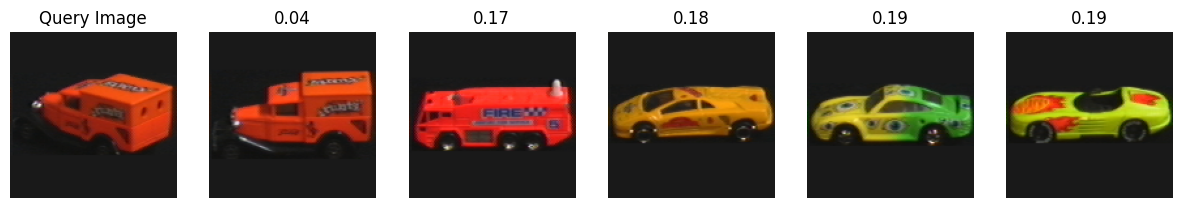

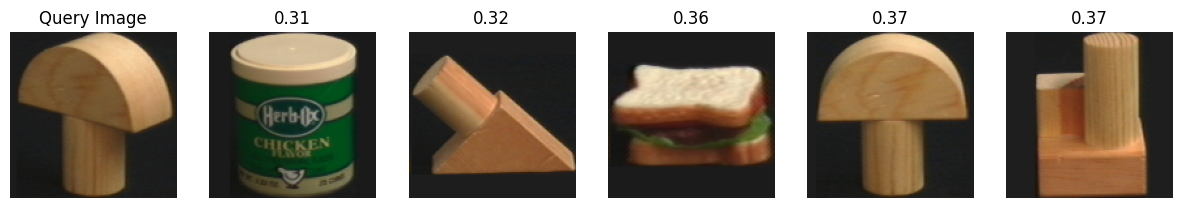

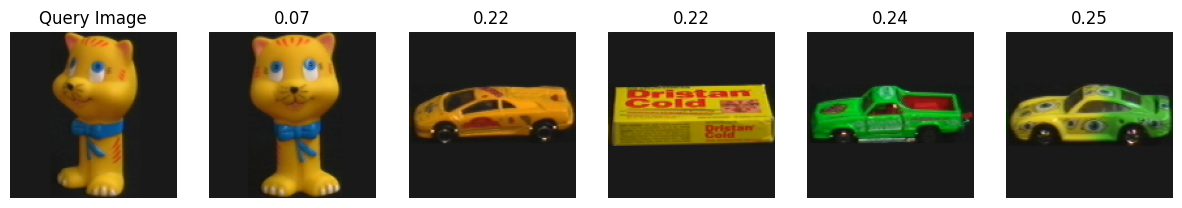

In [86]:
## visualize nearest neighbors
query_images_vis = [query_images[i] for i in np.array([0, 4, 9])]
show_neighbors(model_images, query_images_vis, 'intersect', hist_type, num_bins)

### **4.3: Retrieval Metrics (? points)**
In previous sections, we implemented classical metrics for classification tasks. However, since we've also created a find_best_match function, we can approach this as a retrieval task. This perspective allows us to find the top-k items that best match the input item.
Given this retrieval approach, it's more appropriate to use a metric specifically designed for retrieval tasks.

**Top-k Accuracy**

This is a variation of the classical accuracy metric. Here's how it works:
1. For each input item, we consider the top k results.
2. We count the result as positive if at least one of these k results matches the correct label.

In [ ]:
def topk_accuracy(y_true, y_pred, k:int) -> float:
    """
    Compute the Top-K accuracy, i.e. check whether the
    correct label is in the top-k results.

    Args:
        y_true (list): list of correct labels
        y_pred (np.array): A matrix of size (num_samples, num_results)
            where each cell contains the predicted score for each
            element in the dataset
        k (int): number of best matching items to consider

    Returns:
        topk_accuracy (float)
    """
    # Invert y_pred to make sure higher values represent better matches
    y_pred = -y_pred

    correct_count = 0
    num_samples = len(y_true)

    for i in range(num_samples):
        top_k_indices = np.argsort(y_pred[i])[-k:][::-1]
        if y_true[i] in top_k_indices:
            correct_count += 1
    topk_accuracy = correct_count / num_samples
    return topk_accuracy


--------------------------------------------
**Do not write below this line just run it**

--------------------------------------------

In [ ]:
if 'D' not in globals():
    _,D = find_best_match(
        model_images, query_images, dist_type, hist_type, num_bins
    )
y_true = np.arange(D.shape[0])

topk_accuracy(y_true, D, k=5)

Now that you understand how the Top-$k$ accuracy works:
- Compute the top-k accuracy for each of the values of $k \in \{1,...,20\}$.
- Produce a plot, with the value $k$ on the x-axis and the topk-accuracy on the y-axis.
- Which is the minimum value of $k$ for which the top-$k$ accuracy is at least 80%?
- Which are the tradeoffs of incrementing $k$?


In [ ]:
K = 20
y_true; # These are the correct labels

#####################################################
##                 YOUR CODE HERE                  ##
#####################################################

-------------------------------------------------------


**WRITE YOU ANSWER HERE**


-------------------------------------------------------

...

### **4.4: Analysis and Report** *(1 points)*


Consider again the metrics for the classifier in Question 4.1.
Write the code to compute the metrics for all the possible tresholds in the interval (0.0, 1.0) with increments of 0.5 of `y_pred`.  
Ideally, you should put everything into a pandas DataFrame and print it for a better visualization.  
Then, write a report analyzing you your results. You have complete freedom on your analysis.

Imagine also to be in a medical scenario where your model is predicting the presence or not of a desease and try to answer to the following questions:
- What is the real life trade-off between high precision and high recall? What would you choose?
- Why isn't the accuracy an appropriate measure in such scenario?

In [ ]:
# Use this cell as you'd like

thresholds = np.arange(0.0, 1.1, 0.5)

def compute_metrics_at_thresholds(y_true, y_pred_prob, thresholds):
    metrics = []
    for threshold in thresholds:
        y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred_prob]

        accuracy = accuracy_score(y_true, y_pred_binary)
        precision = precision_score(y_true, y_pred_binary, zero_division=0)
        recall = recall_score(y_true, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, zero_division=0)

        metrics.append({
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    df_metrics = pd.DataFrame(metrics)
    return df_metrics

df_metrics = compute_metrics_at_thresholds(y_test, y_pred, thresholds)
df_metrics